# Kaggle Project 4: Porto Seguro's Safe Driver Predictions - Solution

## Prepared by: Dwaipayan Mukherjee (2211569)


### About the Project:

In this competition, the aim is to predict the probability that an auto insurance policy holder files a claim.

In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix `bin` to indicate binary features and `cat` to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation. The `target` columns signifies whether or not a claim was filed for that policy holder.


### Necessary Imports:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgbm
import catboost
import tensorflow as tf
from tensorflow import keras

### Loading the training data, test data and the submissions data as Pandas Dataframe:

In [3]:
train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test.csv', index_col = 0)
submission = pd.read_csv('sample_submission.csv')

### Understanding the data:

**Checking the head of the datasets:**

In [4]:
train.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


In [5]:
test.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
0,0,1,8,1,0,0,1,0,0,0,...,1,1,1,12,0,1,1,0,0,1
1,4,2,5,1,0,0,0,0,1,0,...,2,0,3,10,0,0,1,1,0,1
2,5,1,3,0,0,0,0,0,1,0,...,4,0,2,4,0,0,0,0,0,0
3,0,1,6,0,0,1,0,0,0,0,...,5,1,0,5,1,0,1,0,0,0
4,5,1,7,0,0,0,0,0,1,0,...,4,0,0,4,0,1,1,0,0,1


In [6]:
submission.head()

,id,target
0,0,0.0364
1,1,0.0364
2,2,0.0364
3,3,0.0364
4,4,0.0364


**Checking for Null Values:**

In [7]:
print('Null Values:\n')
print('\n-----------train-----------\n')
print(train.isna().sum())

print('\n----------test------------\n')
print(test.isna().sum())


Null Values:


-----------train-----------

target            0
ps_ind_01         0
ps_ind_02_cat     0
ps_ind_03         0
ps_ind_04_cat     0
ps_ind_05_cat     0
ps_ind_06_bin     0
ps_ind_07_bin     0
ps_ind_08_bin     0
ps_ind_09_bin     0
ps_ind_10_bin     0
ps_ind_11_bin     0
ps_ind_12_bin     0
ps_ind_13_bin     0
ps_ind_14         0
ps_ind_15         0
ps_ind_16_bin     0
ps_ind_17_bin     0
ps_ind_18_bin     0
ps_reg_01         0
ps_reg_02         0
ps_reg_03         0
ps_car_01_cat     0
ps_car_02_cat     0
ps_car_03_cat     0
ps_car_04_cat     0
ps_car_05_cat     0
ps_car_06_cat     0
ps_car_07_cat     0
ps_car_08_cat     0
ps_car_09_cat     0
ps_car_10_cat     0
ps_car_11_cat     0
ps_car_11         0
ps_car_12         0
ps_car_13         0
ps_car_14         0
ps_car_15         0
ps_calc_01        0
ps_calc_02        0
ps_calc_03        0
ps_calc_04        0
ps_calc_05        0
ps_calc_06        0
ps_calc_07        0
ps_calc_08        0
ps_calc_09        0
ps_calc_10      

**Info about the variables:**

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595212 entries, 7 to 1488027
Data columns (total 58 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   target          595212 non-null  int64  
 1   ps_ind_01       595212 non-null  int64  
 2   ps_ind_02_cat   595212 non-null  int64  
 3   ps_ind_03       595212 non-null  int64  
 4   ps_ind_04_cat   595212 non-null  int64  
 5   ps_ind_05_cat   595212 non-null  int64  
 6   ps_ind_06_bin   595212 non-null  int64  
 7   ps_ind_07_bin   595212 non-null  int64  
 8   ps_ind_08_bin   595212 non-null  int64  
 9   ps_ind_09_bin   595212 non-null  int64  
 10  ps_ind_10_bin   595212 non-null  int64  
 11  ps_ind_11_bin   595212 non-null  int64  
 12  ps_ind_12_bin   595212 non-null  int64  
 13  ps_ind_13_bin   595212 non-null  int64  
 14  ps_ind_14       595212 non-null  int64  
 15  ps_ind_15       595212 non-null  int64  
 16  ps_ind_16_bin   595212 non-null  int64  
 17  ps_ind_17

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 892816 entries, 0 to 1488026
Data columns (total 57 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ps_ind_01       892816 non-null  int64  
 1   ps_ind_02_cat   892816 non-null  int64  
 2   ps_ind_03       892816 non-null  int64  
 3   ps_ind_04_cat   892816 non-null  int64  
 4   ps_ind_05_cat   892816 non-null  int64  
 5   ps_ind_06_bin   892816 non-null  int64  
 6   ps_ind_07_bin   892816 non-null  int64  
 7   ps_ind_08_bin   892816 non-null  int64  
 8   ps_ind_09_bin   892816 non-null  int64  
 9   ps_ind_10_bin   892816 non-null  int64  
 10  ps_ind_11_bin   892816 non-null  int64  
 11  ps_ind_12_bin   892816 non-null  int64  
 12  ps_ind_13_bin   892816 non-null  int64  
 13  ps_ind_14       892816 non-null  int64  
 14  ps_ind_15       892816 non-null  int64  
 15  ps_ind_16_bin   892816 non-null  int64  
 16  ps_ind_17_bin   892816 non-null  int64  
 17  ps_ind_18

**Summary statistics:**

In [10]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
target,595212.0,0.036448,0.187401,0.000000,0.000000,0.000000,0.000000,1.000000
ps_ind_01,595212.0,1.900378,1.983789,0.000000,0.000000,1.000000,3.000000,7.000000
ps_ind_02_cat,595212.0,1.358943,0.664594,-1.000000,1.000000,1.000000,2.000000,4.000000
ps_ind_03,595212.0,4.423318,2.699902,0.000000,2.000000,4.000000,6.000000,11.000000
ps_ind_04_cat,595212.0,0.416794,0.493311,-1.000000,0.000000,0.000000,1.000000,1.000000
ps_ind_05_cat,595212.0,0.405188,1.350642,-1.000000,0.000000,0.000000,0.000000,6.000000
ps_ind_06_bin,595212.0,0.393742,0.488579,0.000000,0.000000,0.000000,1.000000,1.000000
ps_ind_07_bin,595212.0,0.257033,0.436998,0.000000,0.000000,0.000000,1.000000,1.000000
ps_ind_08_bin,595212.0,0.163921,0.370205,0.000000,0.000000,0.000000,0.000000,1.000000
ps_ind_09_bin,595212.0,0.185304,0.388544,0.000000,0.000000,0.000000,0.000000,1.000000


In [11]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
ps_ind_01,892816.0,1.902371,1.986503,0.000000,0.000000,1.000000,3.000000,7.000000
ps_ind_02_cat,892816.0,1.358613,0.663002,-1.000000,1.000000,1.000000,2.000000,4.000000
ps_ind_03,892816.0,4.413734,2.700149,0.000000,2.000000,4.000000,6.000000,11.000000
ps_ind_04_cat,892816.0,0.417361,0.493453,-1.000000,0.000000,0.000000,1.000000,1.000000
ps_ind_05_cat,892816.0,0.408132,1.355068,-1.000000,0.000000,0.000000,0.000000,6.000000
ps_ind_06_bin,892816.0,0.393246,0.488471,0.000000,0.000000,0.000000,1.000000,1.000000
ps_ind_07_bin,892816.0,0.257191,0.437086,0.000000,0.000000,0.000000,1.000000,1.000000
ps_ind_08_bin,892816.0,0.163659,0.369966,0.000000,0.000000,0.000000,0.000000,1.000000
ps_ind_09_bin,892816.0,0.185905,0.389030,0.000000,0.000000,0.000000,0.000000,1.000000
ps_ind_10_bin,892816.0,0.000373,0.019309,0.000000,0.000000,0.000000,0.000000,1.000000


**Dealing with missing values:**

Missing values in features are given as -1. So I need to deal with them.

In here, there are three types of variables: binary, categorical and continuous variables. I first separate out these variables.

First I look at the number of unique values in each variable to make sure the binary, categorical and continuous variables are correctly specified in the dataset:

In [12]:
print("UNIQUE VALUE COUNT\n")

print("\n------------train------------\n")
for i in train.columns:
    print(f'{i}: {train[i].nunique()}')

print("\n------------test------------\n")
for i in test.columns:
    print(f'{i}: {test[i].nunique()}')

UNIQUE VALUE COUNT


------------train------------

target: 2
ps_ind_01: 8
ps_ind_02_cat: 5
ps_ind_03: 12
ps_ind_04_cat: 3
ps_ind_05_cat: 8
ps_ind_06_bin: 2
ps_ind_07_bin: 2
ps_ind_08_bin: 2
ps_ind_09_bin: 2
ps_ind_10_bin: 2
ps_ind_11_bin: 2
ps_ind_12_bin: 2
ps_ind_13_bin: 2
ps_ind_14: 5
ps_ind_15: 14
ps_ind_16_bin: 2
ps_ind_17_bin: 2
ps_ind_18_bin: 2
ps_reg_01: 10
ps_reg_02: 19
ps_reg_03: 5013
ps_car_01_cat: 13
ps_car_02_cat: 3
ps_car_03_cat: 3
ps_car_04_cat: 10
ps_car_05_cat: 3
ps_car_06_cat: 18
ps_car_07_cat: 3
ps_car_08_cat: 2
ps_car_09_cat: 6
ps_car_10_cat: 3
ps_car_11_cat: 104
ps_car_11: 5
ps_car_12: 184
ps_car_13: 70482
ps_car_14: 850
ps_car_15: 15
ps_calc_01: 10
ps_calc_02: 10
ps_calc_03: 10
ps_calc_04: 6
ps_calc_05: 7
ps_calc_06: 11
ps_calc_07: 10
ps_calc_08: 11
ps_calc_09: 8
ps_calc_10: 26
ps_calc_11: 20
ps_calc_12: 11
ps_calc_13: 14
ps_calc_14: 24
ps_calc_15_bin: 2
ps_calc_16_bin: 2
ps_calc_17_bin: 2
ps_calc_18_bin: 2
ps_calc_19_bin: 2
ps_calc_20_bin: 2

------------test----

Separating out the binary, categorical and continuous variables:

In [13]:
bin_vars = [] ## list to store names of binary variables
cat_vars = [] ## list to store names of categorical variables
cont_vars = [] ## list to store names of continuous variables

for i in train.columns:
    if "_bin" in i:
        bin_vars.append(i)
    elif "_cat" in i:
        cat_vars.append(i)
    else:
        cont_vars.append(i)

cont_vars.remove('target')

print("Binary Variables:\n")
print(bin_vars)
print('\n')

print("Categorical Variables:\n")
print(cat_vars)
print('\n')

print("Continuous Variables:\n")
print(cont_vars)
print('\n')

Binary Variables:

['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin']


Categorical Variables:

['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat']


Continuous Variables:

['ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14']




Now I check if any of the binary variables have -1 as a value. To do this, I check the unique values of each of the binary variables:

In [14]:
print("UNIQUE VALUES OF BINARY VARIABLES:\n")

print("\n---------train-----------\n")
for i in bin_vars:
    print(f'Unique values of {i}: {train[i].unique()}')

print("\n---------test-----------\n")
for i in bin_vars:
    print(f'Unique values of {i}: {test[i].unique()}')

UNIQUE VALUES OF BINARY VARIABLES:


---------train-----------

Unique values of ps_ind_06_bin: [0 1]
Unique values of ps_ind_07_bin: [1 0]
Unique values of ps_ind_08_bin: [0 1]
Unique values of ps_ind_09_bin: [0 1]
Unique values of ps_ind_10_bin: [0 1]
Unique values of ps_ind_11_bin: [0 1]
Unique values of ps_ind_12_bin: [0 1]
Unique values of ps_ind_13_bin: [0 1]
Unique values of ps_ind_16_bin: [0 1]
Unique values of ps_ind_17_bin: [1 0]
Unique values of ps_ind_18_bin: [0 1]
Unique values of ps_calc_15_bin: [0 1]
Unique values of ps_calc_16_bin: [1 0]
Unique values of ps_calc_17_bin: [1 0]
Unique values of ps_calc_18_bin: [0 1]
Unique values of ps_calc_19_bin: [0 1]
Unique values of ps_calc_20_bin: [1 0]

---------test-----------

Unique values of ps_ind_06_bin: [0 1]
Unique values of ps_ind_07_bin: [1 0]
Unique values of ps_ind_08_bin: [0 1]
Unique values of ps_ind_09_bin: [0 1]
Unique values of ps_ind_10_bin: [0 1]
Unique values of ps_ind_11_bin: [0 1]
Unique values of ps_ind_12_bi

Thus, there are no missing values in the binary columns.

Next, I check the same for the categorical columns:

In [15]:
print("UNIQUE VALUES OF CATEGORICAL VARIABLES:\n")

print("\n---------train-----------\n")
for i in cat_vars:
    print(f'Unique values of {i}: {train[i].unique()}')

print("\n---------test-----------\n")
for i in cat_vars:
    print(f'Unique values of {i}: {test[i].unique()}')

UNIQUE VALUES OF CATEGORICAL VARIABLES:


---------train-----------

Unique values of ps_ind_02_cat: [ 2  1  4  3 -1]
Unique values of ps_ind_04_cat: [ 1  0 -1]
Unique values of ps_ind_05_cat: [ 0  1  4  3  6  5 -1  2]
Unique values of ps_car_01_cat: [10 11  7  6  9  5  4  8  3  0  2  1 -1]
Unique values of ps_car_02_cat: [ 1  0 -1]
Unique values of ps_car_03_cat: [-1  0  1]
Unique values of ps_car_04_cat: [0 1 8 9 2 6 3 7 4 5]
Unique values of ps_car_05_cat: [ 1 -1  0]
Unique values of ps_car_06_cat: [ 4 11 14 13  6 15  3  0  1 10 12  9 17  7  8  5  2 16]
Unique values of ps_car_07_cat: [ 1 -1  0]
Unique values of ps_car_08_cat: [0 1]
Unique values of ps_car_09_cat: [ 0  2  3  1 -1  4]
Unique values of ps_car_10_cat: [1 0 2]
Unique values of ps_car_11_cat: [ 12  19  60 104  82  99  30  68  20  36 101 103  41  59  43  64  29  95
  24   5  28  87  66  10  26  54  32  38  83  89  49  93   1  22  85  78
  31  34   7   8   3  46  27  25  61  16  69  40  76  39  88  42  75  91
  23   2  71 

Missing values are present in most of the categorical columns, so I need to deal with them. First I will find out the percentage of missing values in each of the categorical columns. This will allow me to understand which columns have more missing values than signals; I can drop out those columns.

In [16]:
## Defining a function to calculate the percentage of missing values in each column
def percent_missing(col, df):
    return (df[col].value_counts()[-1]/df[col].value_counts().sum())

In [17]:
print("PERCENTAGE OF MISSING VALUES IN CATEGORICAL COLUMNS")

print("\n-------train--------\n")
for i in cat_vars:
    if -1 in train[i].unique():
        print(f"Fraction of missing values in {i}: {percent_missing(i, train)}")
    else:
        print(f"Fraction of missing values in {i}: No missing values")

print("\n-------test--------\n")
for i in cat_vars:
    if -1 in test[i].unique():
        print(f"Fraction of missing values in {i}: {percent_missing(i, test)}")
    else:
        print(f"Fraction of missing values in {i}: No missing values")

PERCENTAGE OF MISSING VALUES IN CATEGORICAL COLUMNS

-------train--------

Fraction of missing values in ps_ind_02_cat: 0.0003628959093566662
Fraction of missing values in ps_ind_04_cat: 0.00013944611331760784
Fraction of missing values in ps_ind_05_cat: 0.00975954785857812
Fraction of missing values in ps_car_01_cat: 0.0001797678810239041
Fraction of missing values in ps_car_02_cat: 8.400368272145051e-06
Fraction of missing values in ps_car_03_cat: 0.6908983689844963
Fraction of missing values in ps_car_04_cat: No missing values
Fraction of missing values in ps_car_05_cat: 0.4478253126617071
Fraction of missing values in ps_car_06_cat: No missing values
Fraction of missing values in ps_car_07_cat: 0.019302366215734897
Fraction of missing values in ps_car_08_cat: No missing values
Fraction of missing values in ps_car_09_cat: 0.0009559619093701067
Fraction of missing values in ps_car_10_cat: No missing values
Fraction of missing values in ps_car_11_cat: No missing values

-------test---

The columns `ps_car_03_cat` and `ps_car_05_cat` has the highest percentage of missing values. So, it is rational to drop these from both the train and test dataset.

In [18]:
train.drop(['ps_car_03_cat','ps_car_05_cat'], axis=1, inplace=True)
test.drop(['ps_car_03_cat','ps_car_05_cat'], axis=1, inplace=True)

cat_vars.remove('ps_car_03_cat')
cat_vars.remove('ps_car_05_cat')

Now I use an imputation to fill in the missing values of the remaining categorical variables. I use the mode of each categorical column as the imputed value.

In [19]:
def impute_by_mode(cols, df):
    for i in cols:
        for j in range(0,len(df[i])):
            if df[i].iloc[j] == -1:
                df[i].iloc[j] = df[i].mode()[0]

In [20]:
print("Value counts for train data:\n")
for i in cat_vars:
    print(f'Value counts for {i}\n')
    print(train[i].value_counts())
    print('\n--------------\n')

Value counts for train data:

Value counts for ps_ind_02_cat

 1    431859
 2    123573
 3     28186
 4     11378
-1       216
Name: ps_ind_02_cat, dtype: int64

--------------

Value counts for ps_ind_04_cat

 0    346965
 1    248164
-1        83
Name: ps_ind_04_cat, dtype: int64

--------------

Value counts for ps_ind_05_cat

 0    528009
 6     20662
 4     18344
 1      8322
 3      8233
-1      5809
 2      4184
 5      1649
Name: ps_ind_05_cat, dtype: int64

--------------

Value counts for ps_car_01_cat

 11    207573
 7     179247
 6      62393
 10     50087
 4      26174
 9      20323
 5      18142
 8      15093
 3       6658
 0       5904
 2       2144
 1       1367
-1        107
Name: ps_car_01_cat, dtype: int64

--------------

Value counts for ps_car_02_cat

 1    493990
 0    101217
-1         5
Name: ps_car_02_cat, dtype: int64

--------------

Value counts for ps_car_04_cat

0    496581
1     32115
2     23770
8     20598
9     19034
6      1560
3       640
5       54

In [21]:
impute_by_mode(cat_vars, train)

print("Value counts for train data after imputation:\n")
for i in cat_vars:
    print(f'Value counts for {i}\n')
    print(train[i].value_counts())
    print('\n--------------\n')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Value counts for train data after imputation:

Value counts for ps_ind_02_cat

1    432075
2    123573
3     28186
4     11378
Name: ps_ind_02_cat, dtype: int64

--------------

Value counts for ps_ind_04_cat

0    347048
1    248164
Name: ps_ind_04_cat, dtype: int64

--------------

Value counts for ps_ind_05_cat

0    533818
6     20662
4     18344
1      8322
3      8233
2      4184
5      1649
Name: ps_ind_05_cat, dtype: int64

--------------

Value counts for ps_car_01_cat

11    207680
7     179247
6      62393
10     50087
4      26174
9      20323
5      18142
8      15093
3       6658
0       5904
2       2144
1       1367
Name: ps_car_01_cat, dtype: int64

--------------

Value counts for ps_car_02_cat

1    493995
0    101217
Name: ps_car_02_cat, dtype: int64

--------------

Value counts for ps_car_04_cat

0    496581
1     32115
2     23770
8     20598
9     19034
6      1560
3       640
5       545
4       230
7       139
Name: ps_car_04_cat, dtype: int64

--------------


In [22]:
print("Value counts for test data:\n")
for i in cat_vars:
    print(f'Value counts for {i}\n')
    print(test[i].value_counts())
    print('\n--------------\n')

Value counts for test data:

Value counts for ps_ind_02_cat

 1    647468
 2    186174
 3     41986
 4     16881
-1       307
Name: ps_ind_02_cat, dtype: int64

--------------

Value counts for ps_ind_04_cat

 0    519899
 1    372772
-1       145
Name: ps_ind_04_cat, dtype: int64

--------------

Value counts for ps_ind_05_cat

 0    791403
 6     31215
 4     27362
 3     12521
 1     12415
-1      8710
 2      6523
 5      2667
Name: ps_ind_05_cat, dtype: int64

--------------

Value counts for ps_car_01_cat

 11    311152
 7     270370
 6      93386
 10     74500
 4      39546
 9      30178
 5      26940
 8      22510
 3      10024
 0       8940
 2       3098
 1       2012
-1        160
Name: ps_car_01_cat, dtype: int64

--------------

Value counts for ps_car_02_cat

 1    740989
 0    151822
-1         5
Name: ps_car_02_cat, dtype: int64

--------------

Value counts for ps_car_04_cat

0    744753
1     48446
2     35318
8     30613
9     28823
6      2377
3      1073
5       785

In [23]:
impute_by_mode(cat_vars, test)

print("Value counts for test data after imputation:\n")
for i in cat_vars:
    print(f'Value counts for {i}\n')
    print(test[i].value_counts())
    print('\n--------------\n')

Value counts for test data after imputation:

Value counts for ps_ind_02_cat

1    647775
2    186174
3     41986
4     16881
Name: ps_ind_02_cat, dtype: int64

--------------

Value counts for ps_ind_04_cat

0    520044
1    372772
Name: ps_ind_04_cat, dtype: int64

--------------

Value counts for ps_ind_05_cat

0    800113
6     31215
4     27362
3     12521
1     12415
2      6523
5      2667
Name: ps_ind_05_cat, dtype: int64

--------------

Value counts for ps_car_01_cat

11    311312
7     270370
6      93386
10     74500
4      39546
9      30178
5      26940
8      22510
3      10024
0       8940
2       3098
1       2012
Name: ps_car_01_cat, dtype: int64

--------------

Value counts for ps_car_02_cat

1    740994
0    151822
Name: ps_car_02_cat, dtype: int64

--------------

Value counts for ps_car_04_cat

0    744753
1     48446
2     35318
8     30613
9     28823
6      2377
3      1073
5       785
4       397
7       231
Name: ps_car_04_cat, dtype: int64

--------------



Checking whether all the missing values in categorical columns have been dealt with or not:

In [24]:
print("PERCENTAGE OF MISSING VALUES IN CATEGORICAL COLUMNS")

print("\n-------train--------\n")
for i in cat_vars:
    if -1 in train[i].unique():
        print(f"Fraction of missing values in {i}: {percent_missing(i, train)}")
    else:
        print(f"Fraction of missing values in {i}: No missing values")

print("\n-------test--------\n")
for i in cat_vars:
    if -1 in test[i].unique():
        print(f"Fraction of missing values in {i}: {percent_missing(i, test)}")
    else:
        print(f"Fraction of missing values in {i}: No missing values")

PERCENTAGE OF MISSING VALUES IN CATEGORICAL COLUMNS

-------train--------

Fraction of missing values in ps_ind_02_cat: No missing values
Fraction of missing values in ps_ind_04_cat: No missing values
Fraction of missing values in ps_ind_05_cat: No missing values
Fraction of missing values in ps_car_01_cat: No missing values
Fraction of missing values in ps_car_02_cat: No missing values
Fraction of missing values in ps_car_04_cat: No missing values
Fraction of missing values in ps_car_06_cat: No missing values
Fraction of missing values in ps_car_07_cat: No missing values
Fraction of missing values in ps_car_08_cat: No missing values
Fraction of missing values in ps_car_09_cat: No missing values
Fraction of missing values in ps_car_10_cat: No missing values
Fraction of missing values in ps_car_11_cat: No missing values

-------test--------

Fraction of missing values in ps_ind_02_cat: No missing values
Fraction of missing values in ps_ind_04_cat: No missing values
Fraction of missing v

In [25]:
print("PERCENTAGE OF MISSING VALUES IN CONTINUOUS COLUMNS")

print("\n-------train--------\n")
for i in cont_vars:
    if -1 in train[i].unique():
        print(f"Fraction of missing values in {i}: {percent_missing(i, train)}")
    else:
        print(f"Fraction of missing values in {i}: No missing values")

print("\n-------test--------\n")
for i in cont_vars:
    if -1 in test[i].unique():
        print(f"Fraction of missing values in {i}: {percent_missing(i, test)}")
    else:
        print(f"Fraction of missing values in {i}: No missing values")

PERCENTAGE OF MISSING VALUES IN CONTINUOUS COLUMNS

-------train--------

Fraction of missing values in ps_ind_01: No missing values
Fraction of missing values in ps_ind_03: No missing values
Fraction of missing values in ps_ind_14: No missing values
Fraction of missing values in ps_ind_15: No missing values
Fraction of missing values in ps_reg_01: No missing values
Fraction of missing values in ps_reg_02: No missing values
Fraction of missing values in ps_reg_03: 0.18106489788512328
Fraction of missing values in ps_car_11: 8.400368272145051e-06
Fraction of missing values in ps_car_12: 1.68007365442901e-06
Fraction of missing values in ps_car_13: No missing values
Fraction of missing values in ps_car_14: 0.07160473915176441
Fraction of missing values in ps_car_15: No missing values
Fraction of missing values in ps_calc_01: No missing values
Fraction of missing values in ps_calc_02: No missing values
Fraction of missing values in ps_calc_03: No missing values
Fraction of missing values 

In [26]:
def impute_by_mean(cols, df):
    for i in cols:
        for j in range(0,len(df[i])):
            if df[i].iloc[j] == -1:
                df[i].iloc[j] = df[i].mean()

In [27]:
impute_by_mean(cont_vars, train)
impute_by_mean(cont_vars, test)

In [28]:
print("PERCENTAGE OF MISSING VALUES IN CONTINUOUS COLUMNS")

print("\n-------train--------\n")
for i in cont_vars:
    if -1 in train[i].unique():
        print(f"Fraction of missing values in {i}: {percent_missing(i, train)}")
    else:
        print(f"Fraction of missing values in {i}: No missing values")

print("\n-------test--------\n")
for i in cont_vars:
    if -1 in test[i].unique():
        print(f"Fraction of missing values in {i}: {percent_missing(i, test)}")
    else:
        print(f"Fraction of missing values in {i}: No missing values")

PERCENTAGE OF MISSING VALUES IN CONTINUOUS COLUMNS

-------train--------

Fraction of missing values in ps_ind_01: No missing values
Fraction of missing values in ps_ind_03: No missing values
Fraction of missing values in ps_ind_14: No missing values
Fraction of missing values in ps_ind_15: No missing values
Fraction of missing values in ps_reg_01: No missing values
Fraction of missing values in ps_reg_02: No missing values
Fraction of missing values in ps_reg_03: No missing values
Fraction of missing values in ps_car_11: No missing values
Fraction of missing values in ps_car_12: No missing values
Fraction of missing values in ps_car_13: No missing values
Fraction of missing values in ps_car_14: No missing values
Fraction of missing values in ps_car_15: No missing values
Fraction of missing values in ps_calc_01: No missing values
Fraction of missing values in ps_calc_02: No missing values
Fraction of missing values in ps_calc_03: No missing values
Fraction of missing values in ps_calc_

Thus, missing values have been dealt with.

### Exploratory Data Analysis:

I first look at the distribution of the `target` variable:

([<matplotlib.patches.Wedge at 0x21f8304fdf0>,
 [Text(-1.0927968250049034, 0.12567855528769717, '0: Insurance not claimed'),
  Text(1.0927968220631843, -0.1256785808664532, '1: Insurance claimed')],
 [Text(-0.59607099545722, 0.0685519392478348, '96.4%'),
  Text(0.5960709938526458, -0.06855195319988355, '3.6%')])

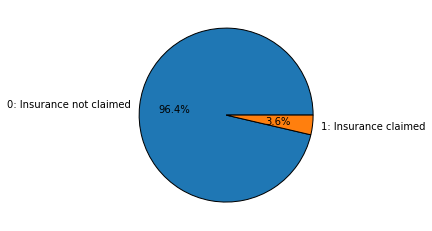

In [29]:
plot_data_train = train['target'].value_counts()
plot_labels_train = plot_data_train.rename(index={0:'0: Insurance not claimed', 1:'1: Insurance claimed'}).index
plt.pie(plot_data_train, labels=plot_labels_train, autopct='%1.1f%%', wedgeprops = dict(edgecolor='black'))

So, the `train` data is highly imbalanced. Only 3.6% have claimed insurance. I will therefore use Stratified K-fold CV while training and cross-validating the models.

Next, I analyze the different variables being used:

Features distribution in the data:

No. of binary features:  17
No. of categorical features:  12
No. of continuous features:  26


([<matplotlib.patches.Wedge at 0x21f830ce880>,
 [Text(0.6208875314790953, 0.9080190930006898, 'Binary features'),
  Text(-0.957820696801988, 0.54090619591363, 'Categorical features'),
  Text(0.0941325223863866, -1.095964902827265, 'Continuous features')],
 [Text(0.3386659262613247, 0.49528314163673987, '30.9%'),
  Text(-0.5224476528010843, 0.2950397432256163, '21.8%'),
  Text(0.05134501221075632, -0.5977990379057808, '47.3%')])

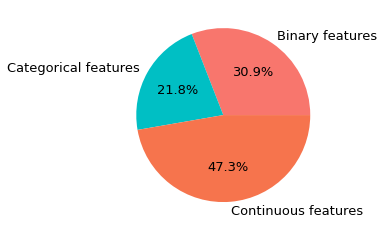

In [30]:
print('Features distribution in the data:\n')
print('No. of binary features: ', len(bin_vars))
print('No. of categorical features: ', len(cat_vars))
print('No. of continuous features: ', len(cont_vars))

plt.pie([len(bin_vars),len(cat_vars), len(cont_vars)],
        labels = ['Binary features','Categorical features', 'Continuous features'],
        colors = ['#F8766D', '#00BFC4', '#F6744D'],
        textprops = {'fontsize': 13},
        autopct = '%1.1f%%')

In [31]:
def eda_by_vars(var_list, data_train, data_test, categorical):
    """
    This fuction does a complete eda on each variable(column).
    
    """
    colors = sns.cubehelix_palette()
    if categorical == True:
        
        for i in var_list:
            
            ## xticks:
            xticks_train = list(data_train[i].unique())
            xticks_test = list(data_test[i].unique())
            
            ## merging xticks_train, xticks_test and xticks_original
            xticks = list(OrderedDict.fromkeys(xticks_train + xticks_test))
            if all([str(item).isdigit() for item in xticks]): xticks.sort()
            
            # figure, axes
            sns.set_style('darkgrid')
            fig, ax = plt.subplots(1, 2, figsize=(14,5))
            # figure title
            fig.suptitle(i, fontsize=16)
            
            ## train / test / original differences:
            pct_train = data_train[i].value_counts(normalize=True).reindex(xticks)
            pct_test = data_test[i].value_counts(normalize=True).reindex(xticks)
            
            pct_train.plot(kind = 'bar',
                           align = 'edge',
                           width = -0.5,
                           ax = ax[0],
                           color = colors[0],
                           edgecolor = 'black')
            
            pct_test.plot(kind = 'bar',
                          align = 'edge',
                          width = 0.5,
                          ax = ax[0],
                          color = colors[1],
                          edgecolor = 'black')
            
            ax[0].set_ylabel('Percent', fontsize=12)
            ax[0].legend(['Train', 'Test'])
            
            ## Claim likelihood:
            sns.pointplot(data = data_train,
                          x = i,
                          y = 'target',
                          color = 'gray',
                          ax = ax[1])
            ax[1].tick_params(axis='x', labelsize=8, rotation=90)
            ax[1].set_xlabel('')
            ax[1].set_ylabel('Claim Likelihood', fontsize=12)
            
    else:
        
        for i in var_list:
            
            # figure, axes
            sns.set_style('darkgrid')
            fig, ax = plt.subplots(1, 2, figsize=(24,5))
            # figure title
            fig.suptitle(i, fontsize=16)

            # train / test / original differences
            sns.kdeplot(data_train[i], shade=True, color=colors[5], ax=ax[0], label='Train', alpha=0.1, linewidth=3)
            sns.kdeplot(data_test[i], shade=True, color=colors[3], ax=ax[0], label='Test', alpha=0.1, linewidth=3)
        
            ax[0].set_xlabel('')
            ax[0].set_ylabel('Density')
            handles, labels = ax[0].get_legend_handles_labels()
            ax[0].legend(handles, labels)
    

    
            # boxplot
            sns.boxplot(y=i, x='target', data=data_train, width=0.3, ax=ax[1], palette=colors, linewidth=3)
            ax[1].set_xlabel('Insurance Claim')
            ax[1].set_ylabel('')
            

EDA of the binary variables:

BINARY VARIABLES


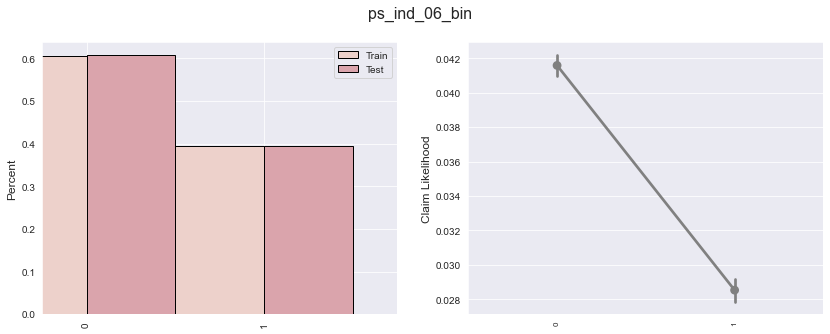

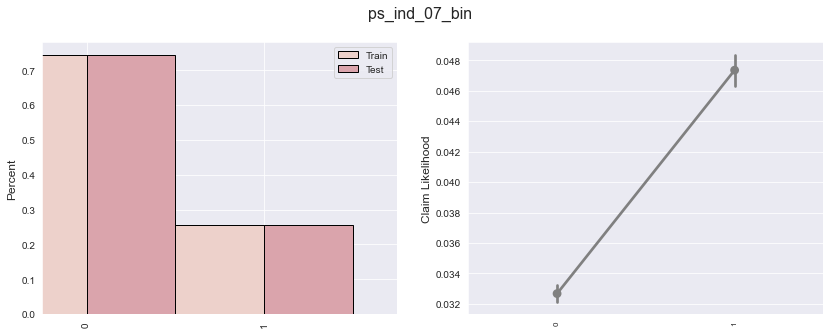

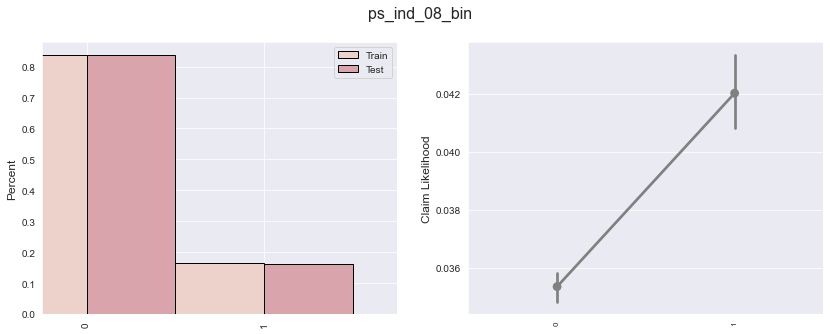

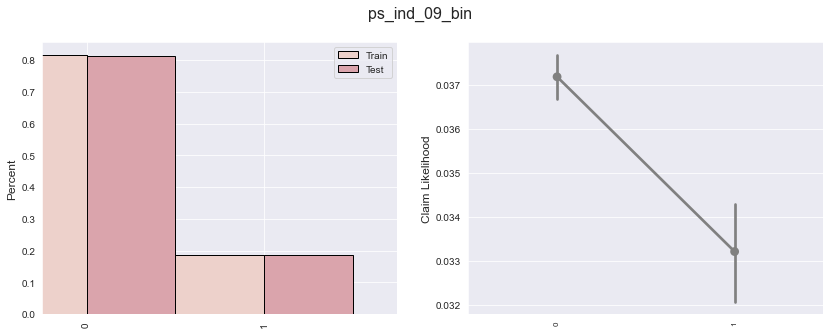

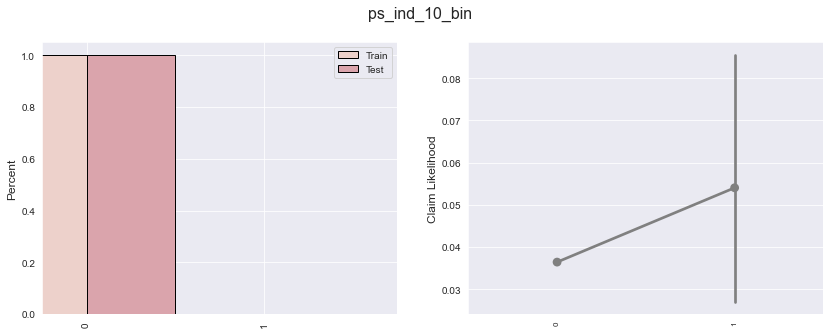

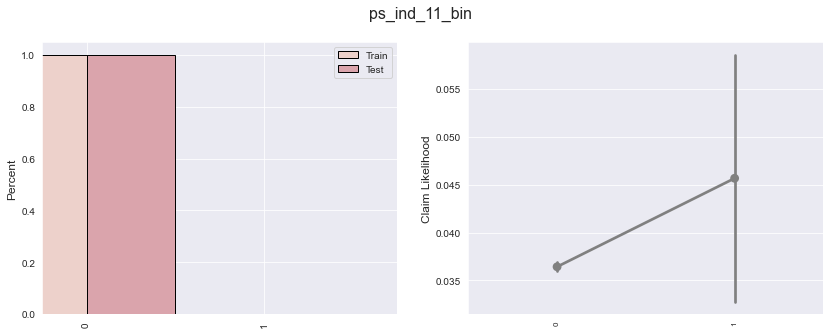

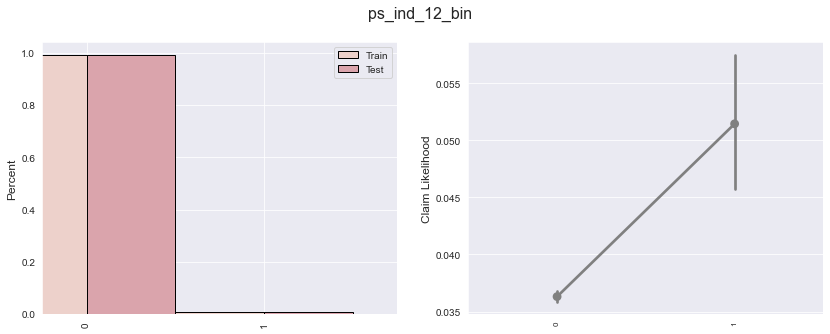

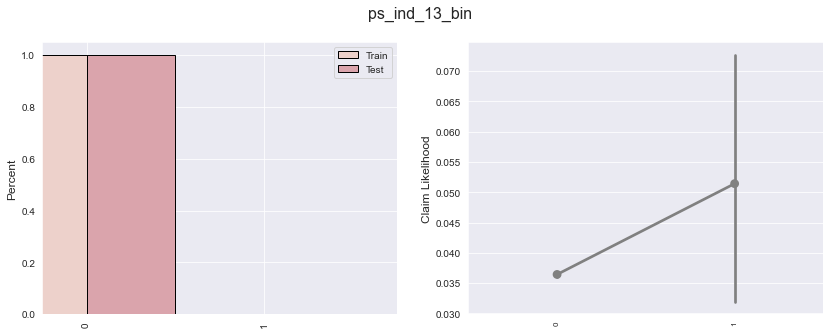

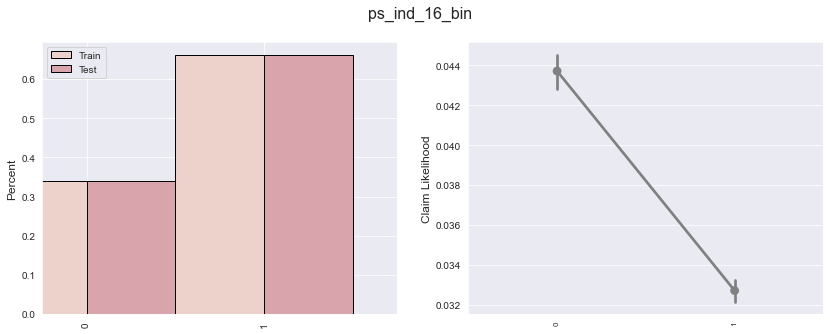

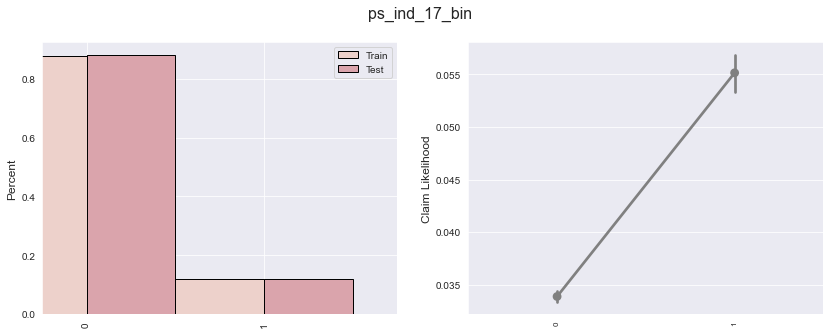

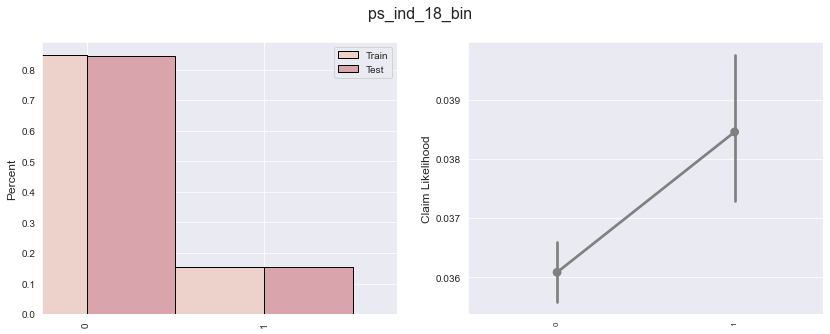

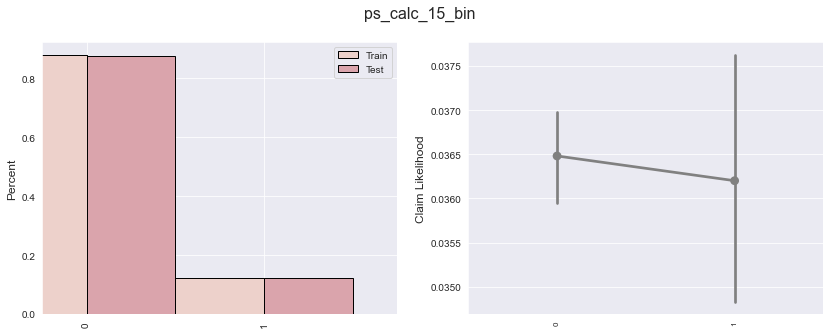

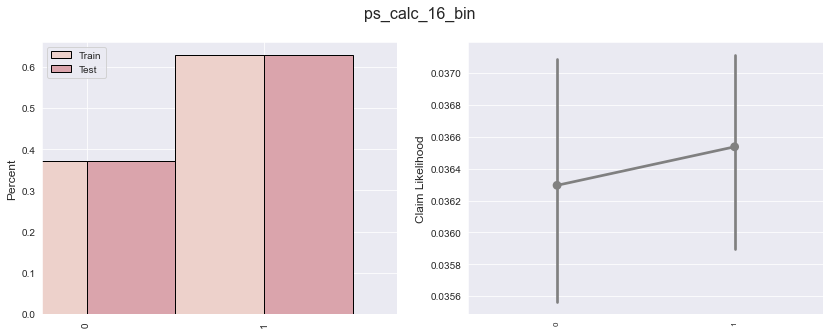

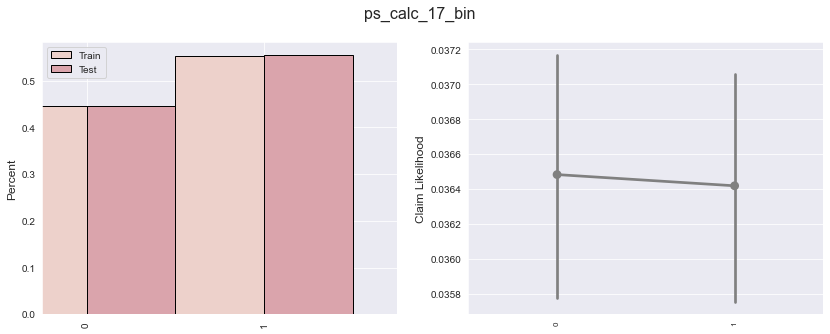

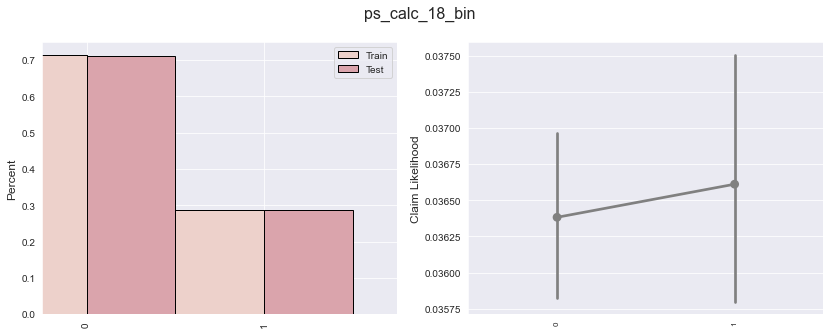

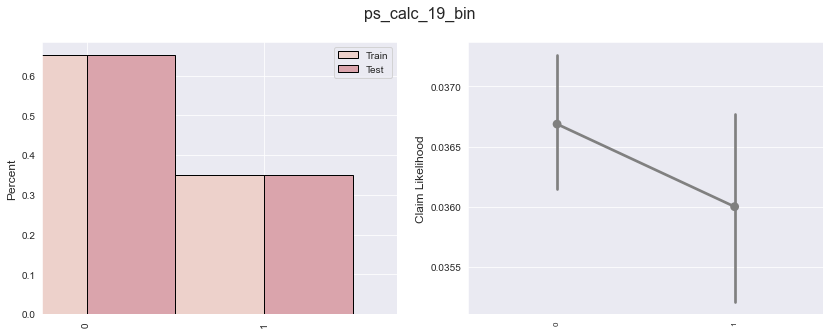

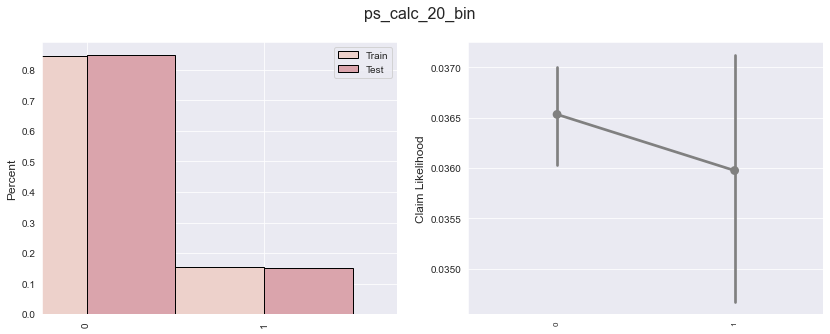

In [32]:
print("BINARY VARIABLES")
eda_by_vars(bin_vars, train, test, categorical=True)

CATEGORICAL VARIABLES


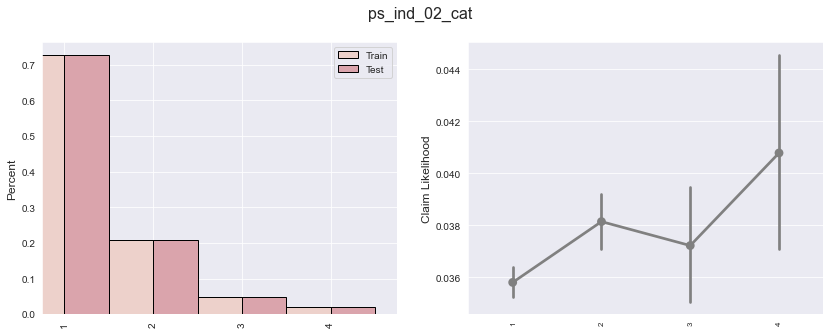

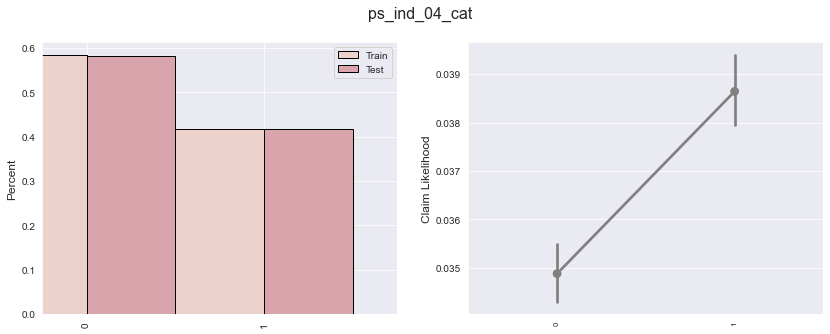

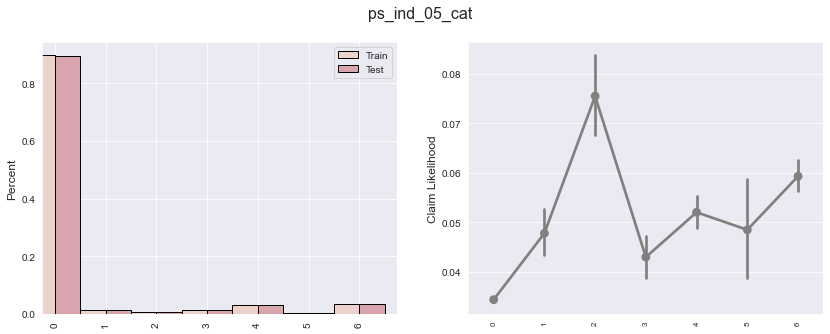

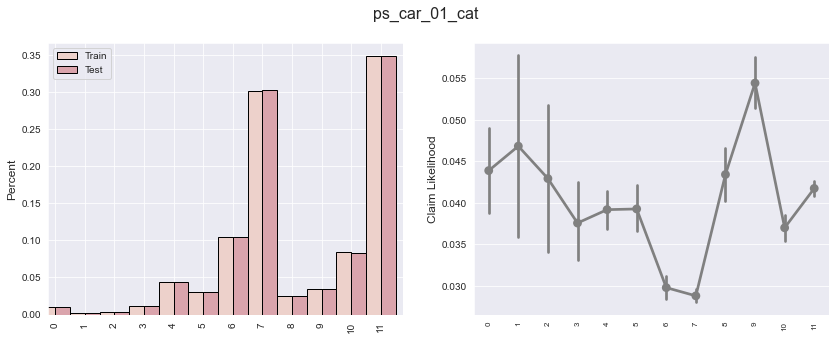

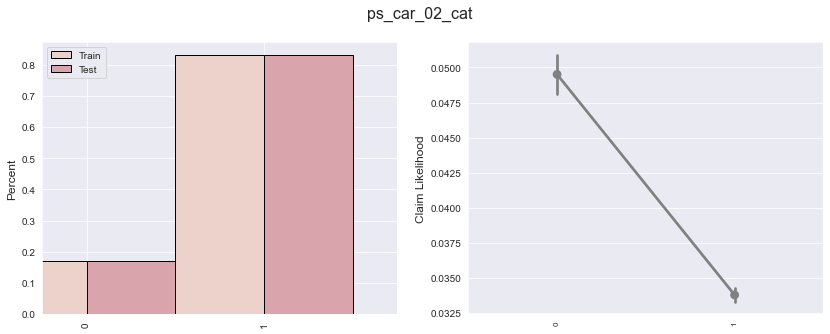

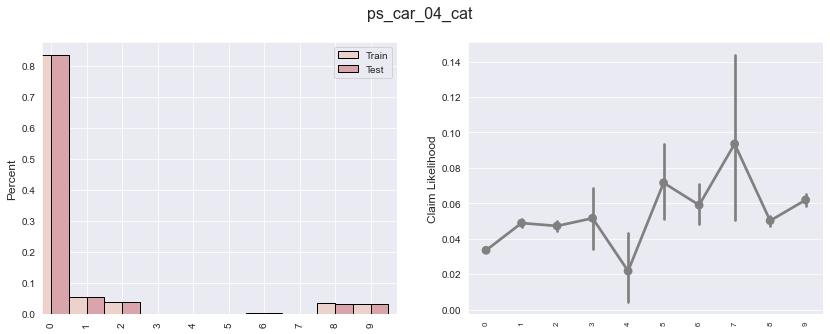

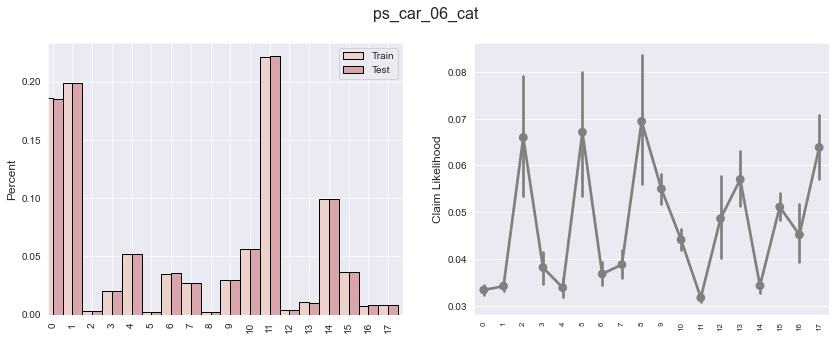

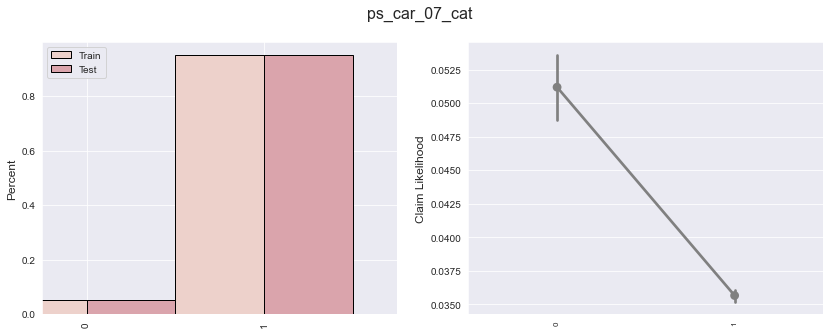

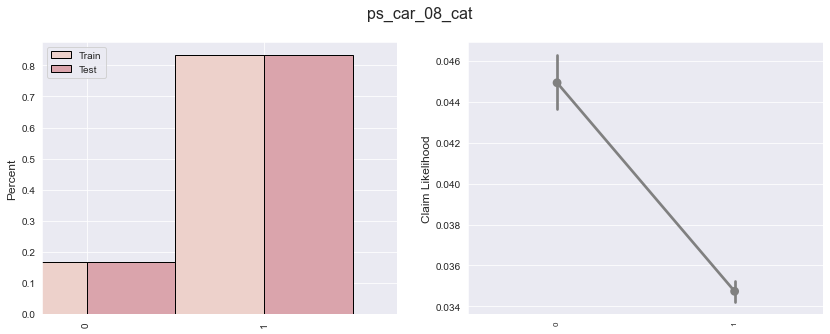

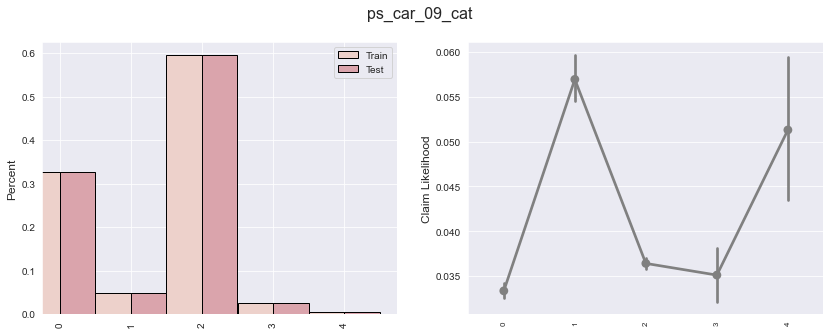

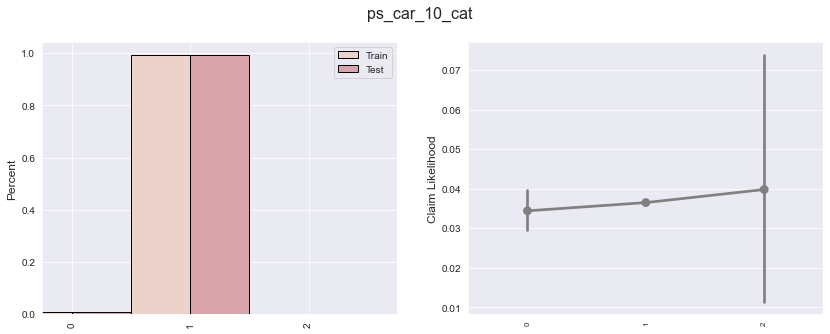

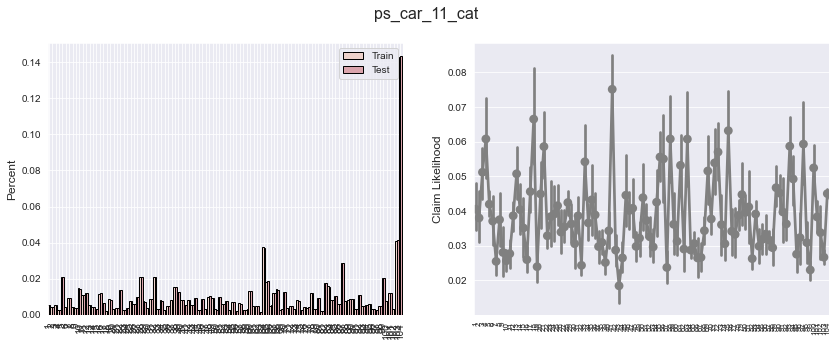

In [33]:
print("CATEGORICAL VARIABLES")
eda_by_vars(cat_vars, train, test, categorical=True)

CONTINUOUS VARIABLES


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
<ipython-input-31-75791464f08c>:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 2, figsize=(24,5))
<ipython-input-31-75791464f08c>:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure

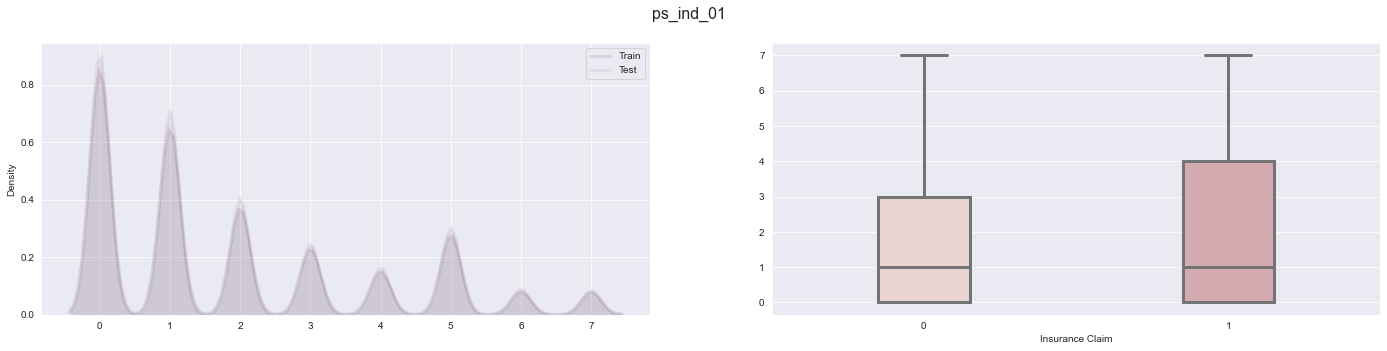

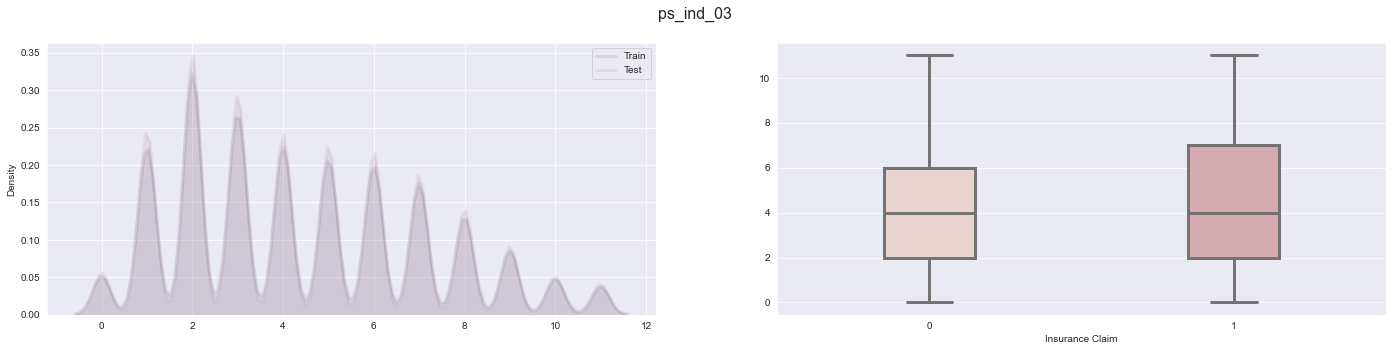

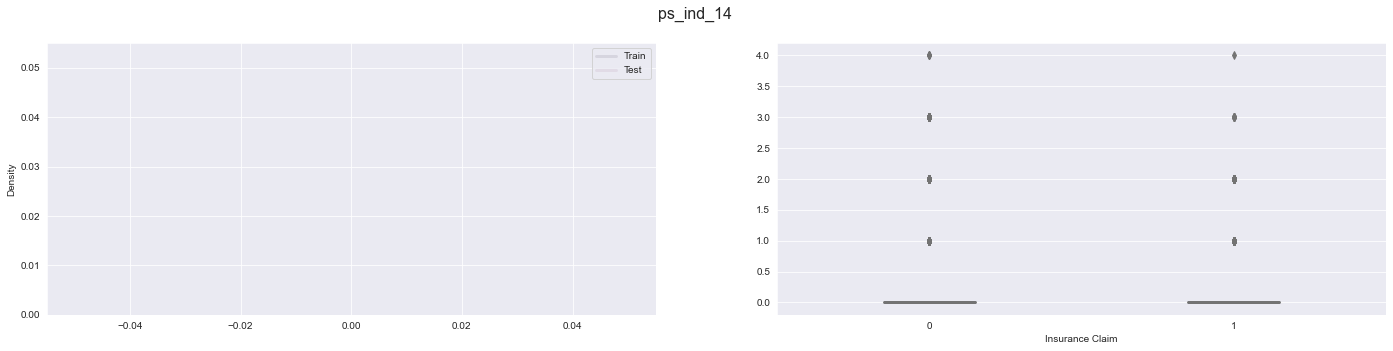

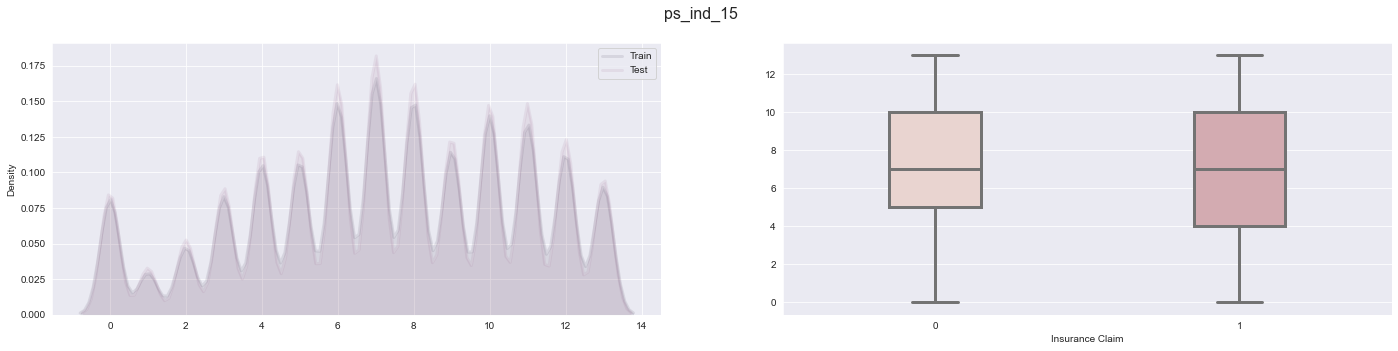

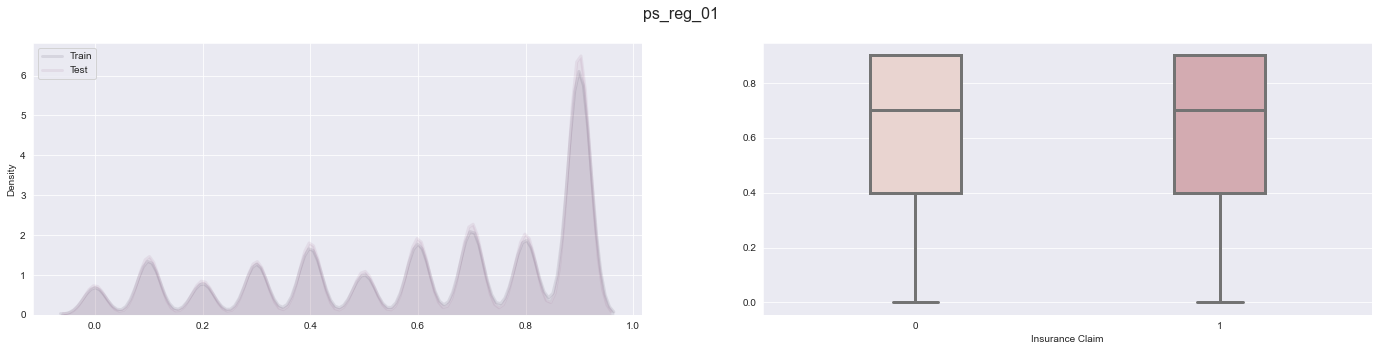

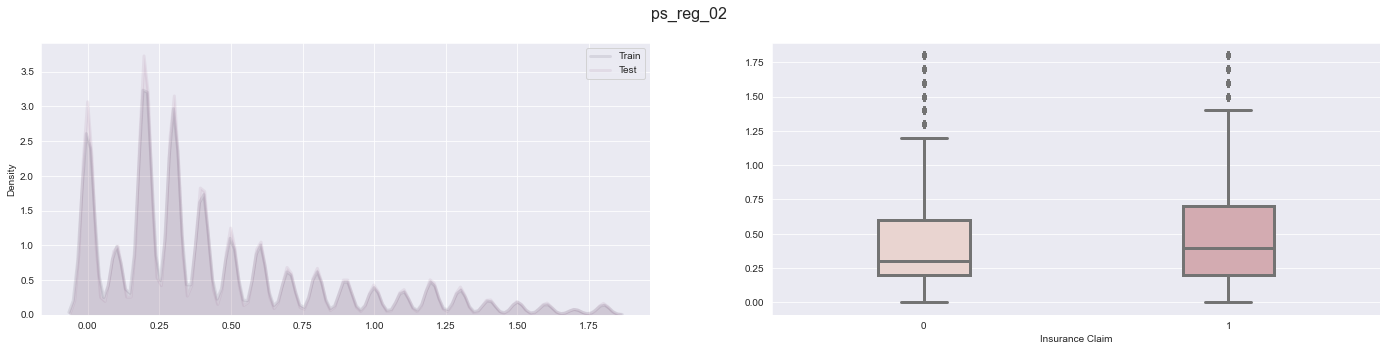

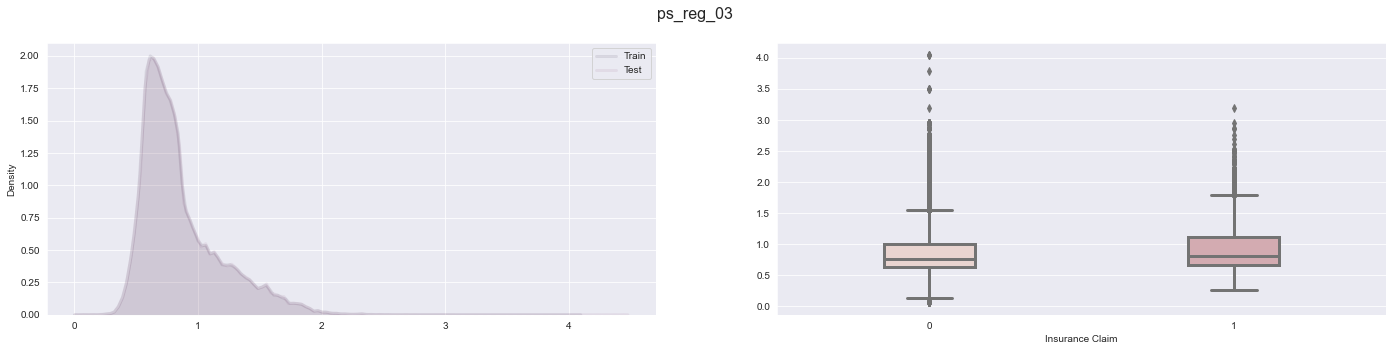

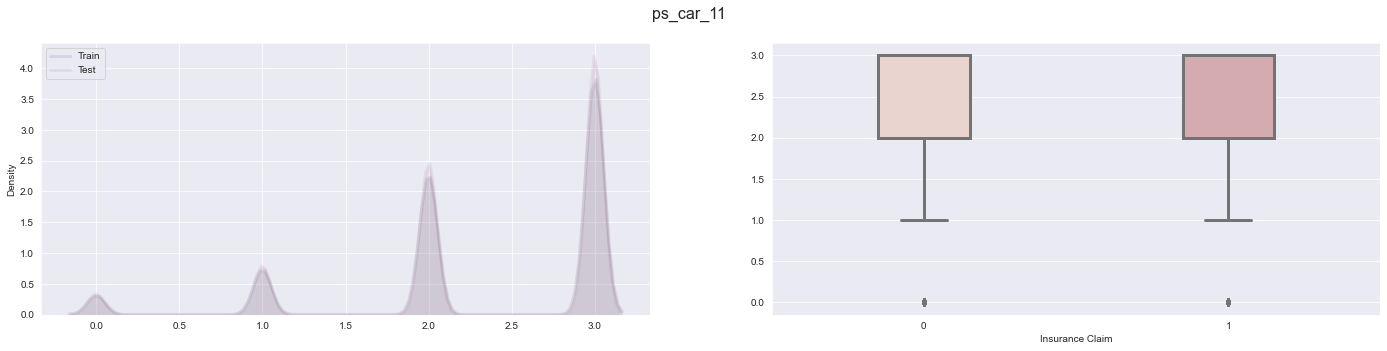

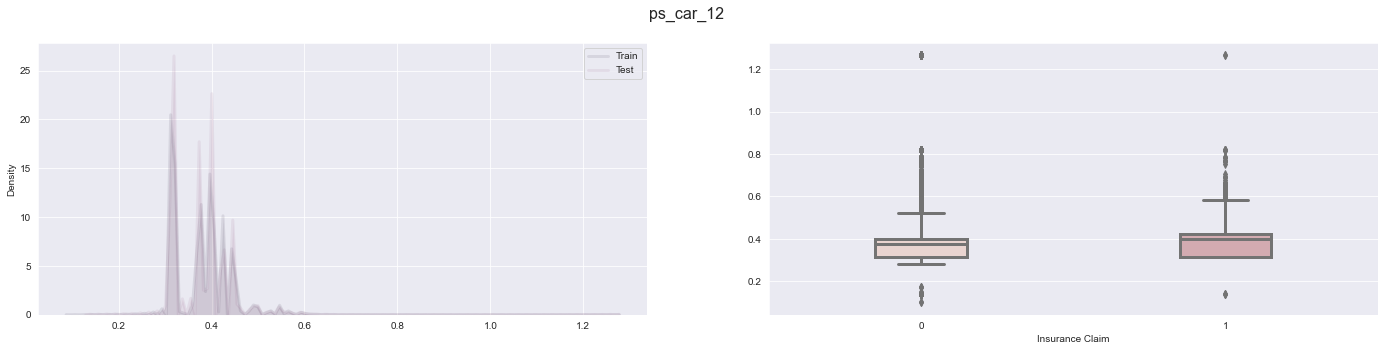

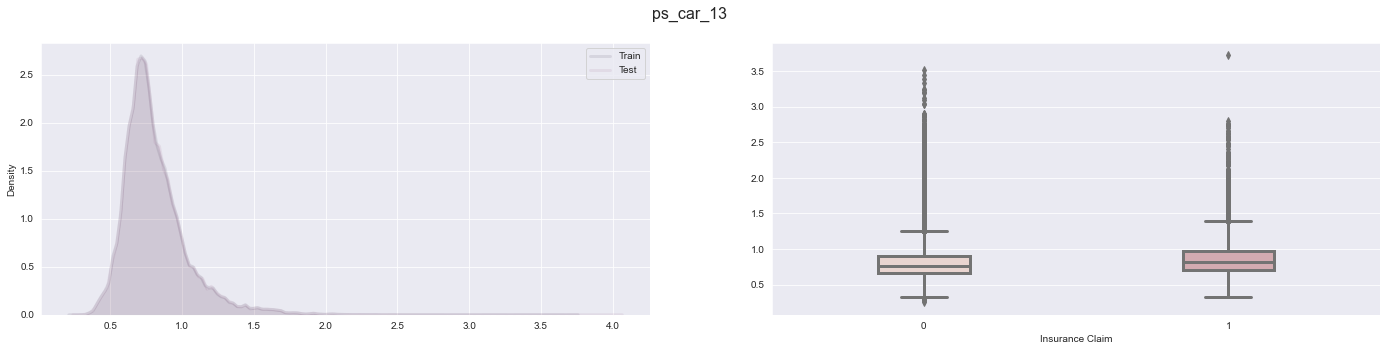

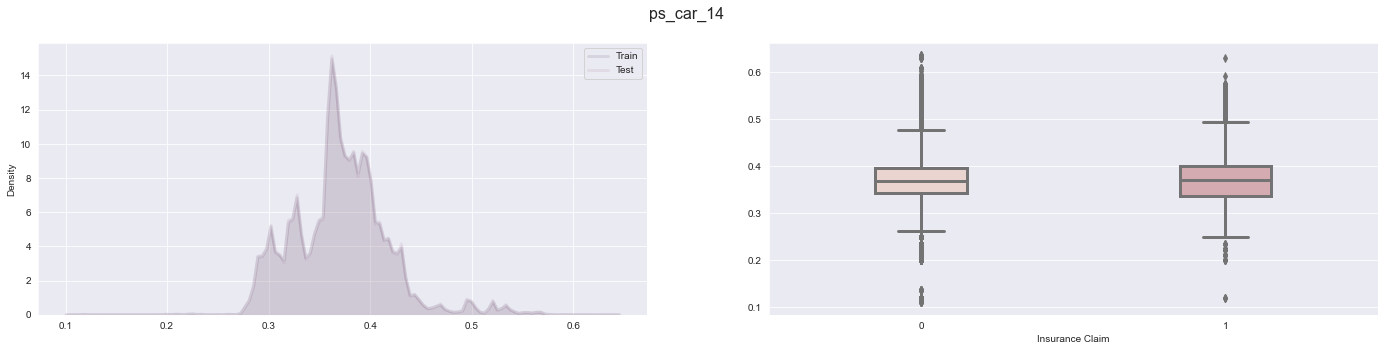

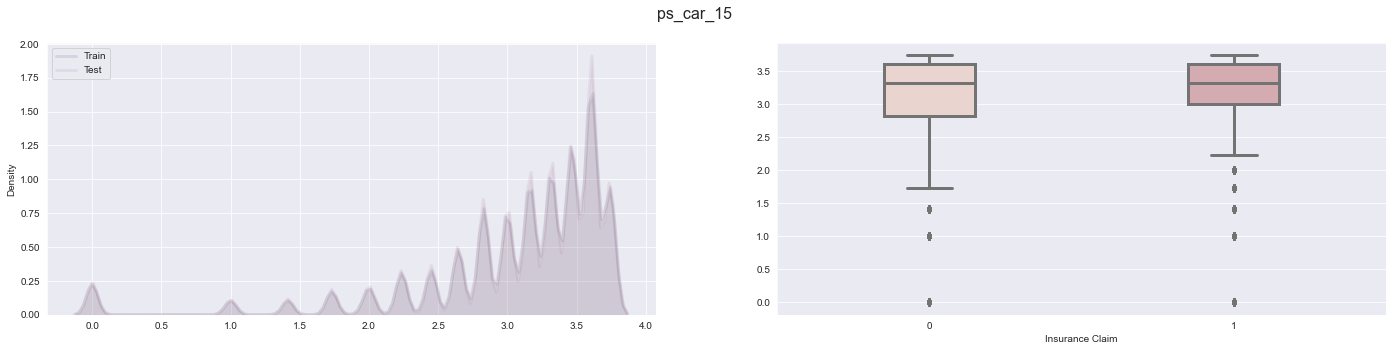

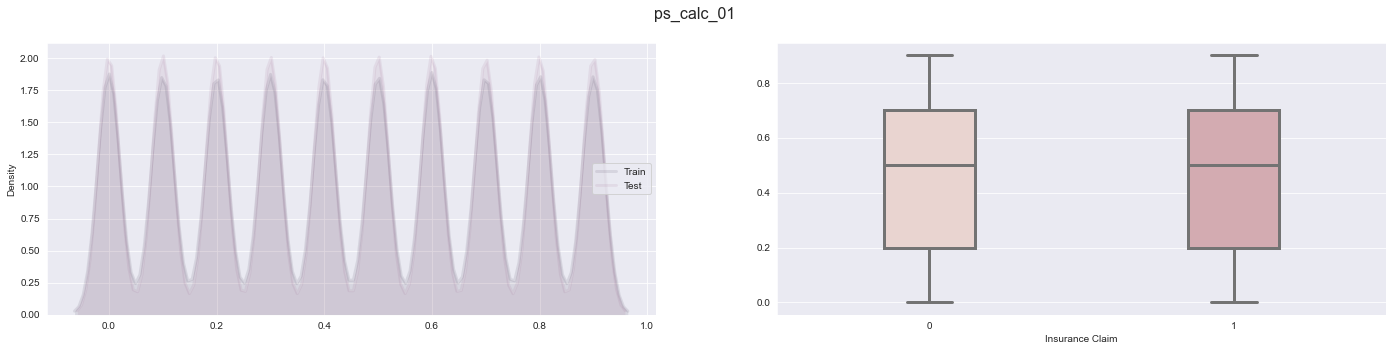

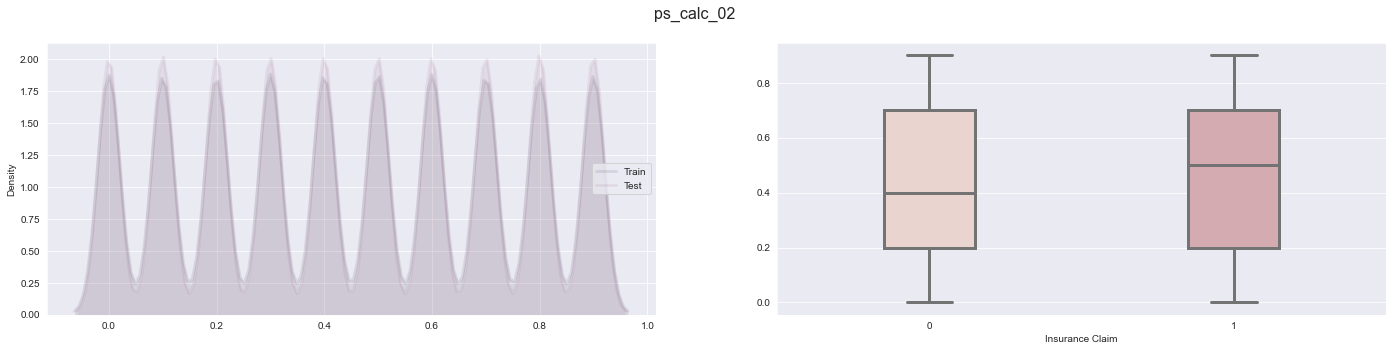

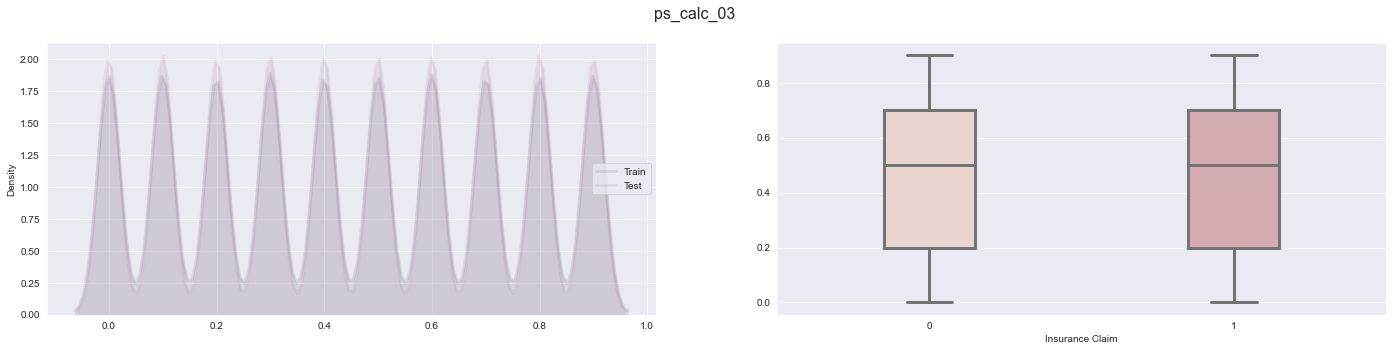

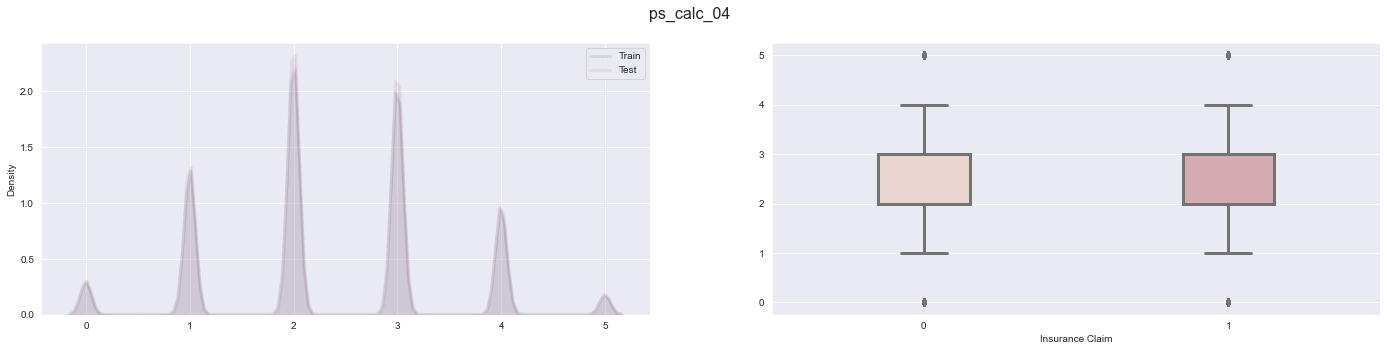

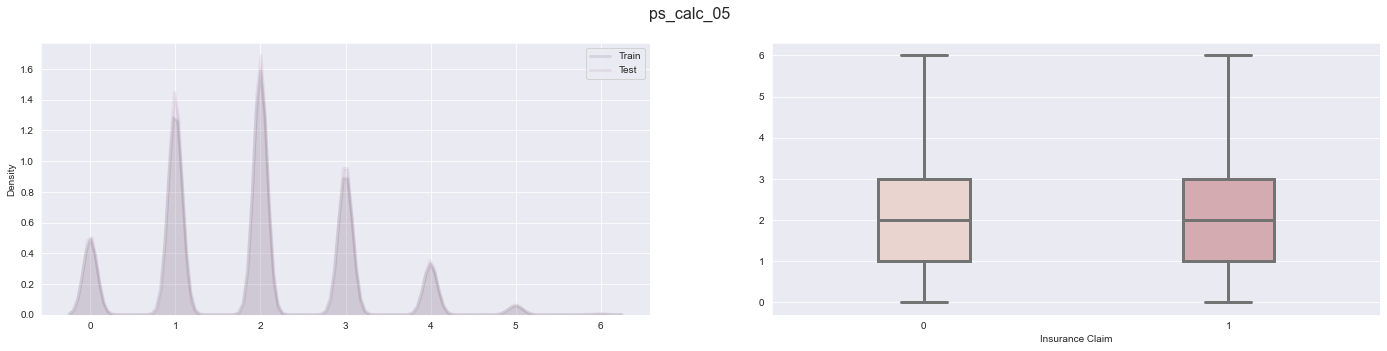

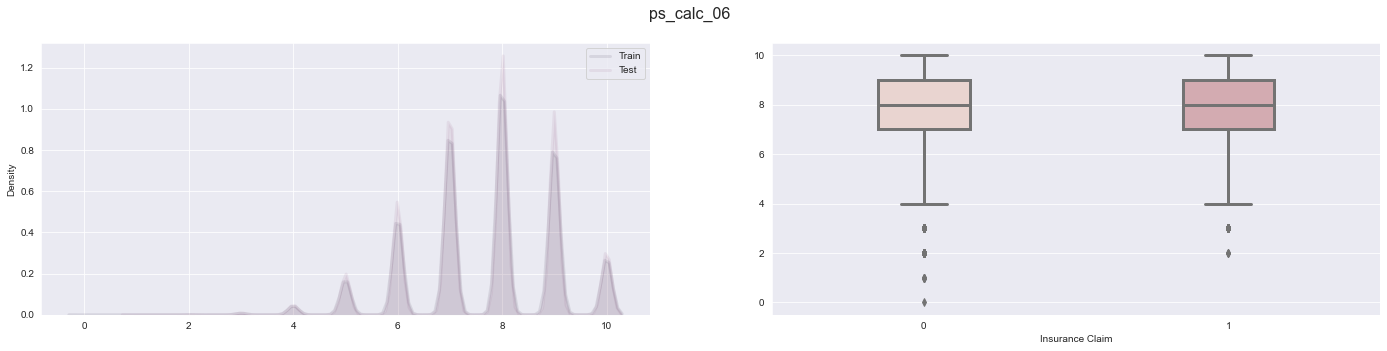

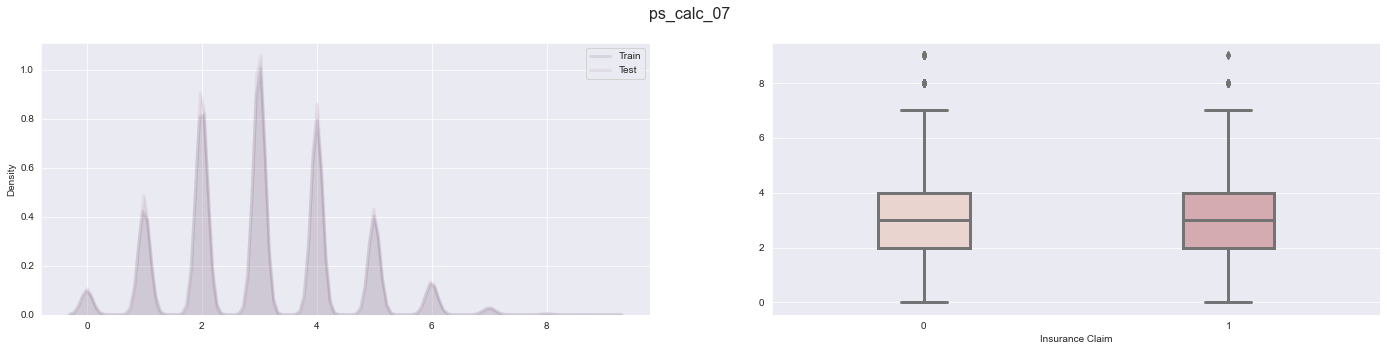

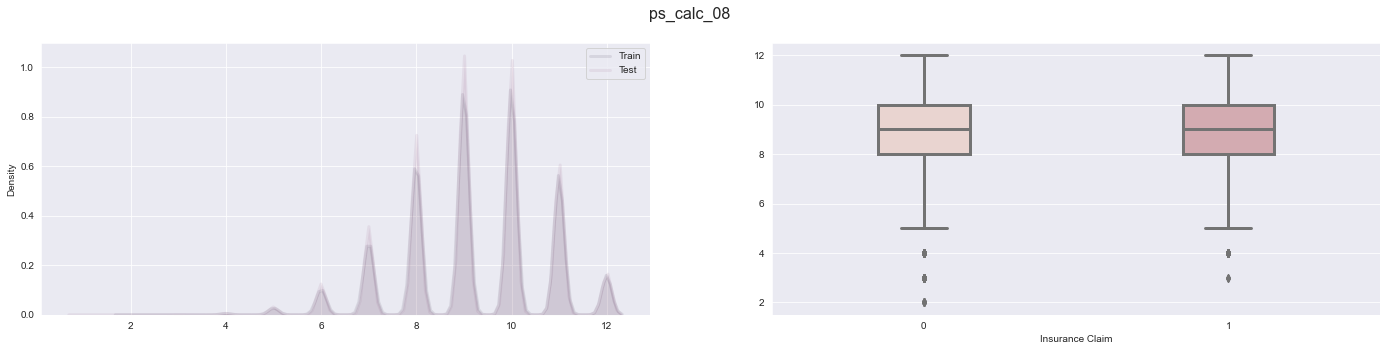

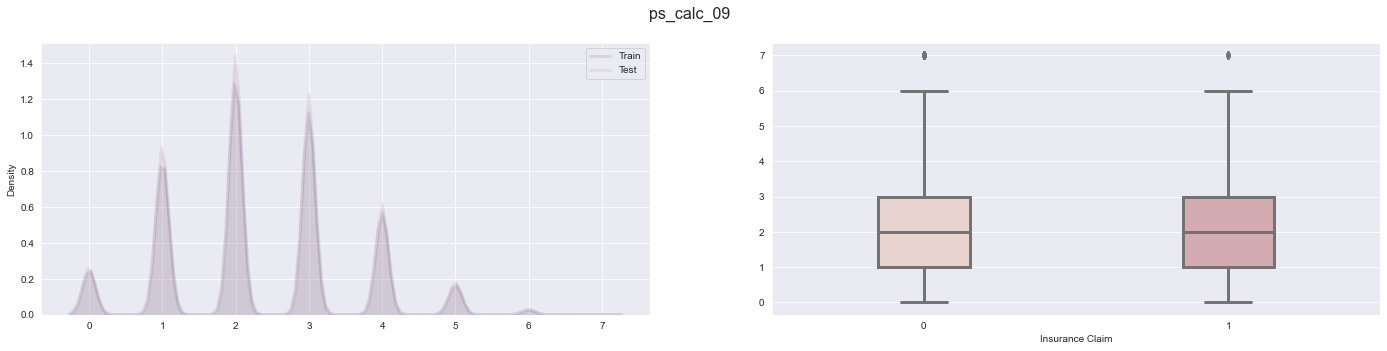

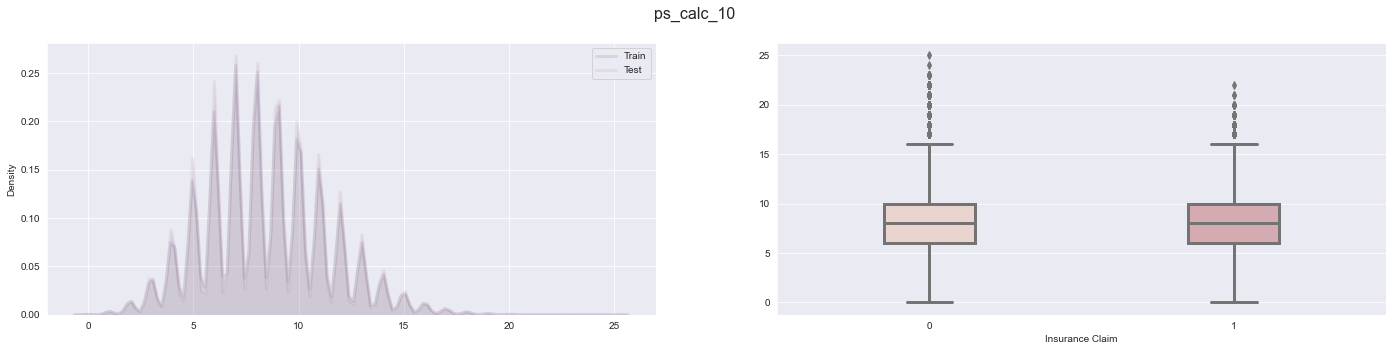

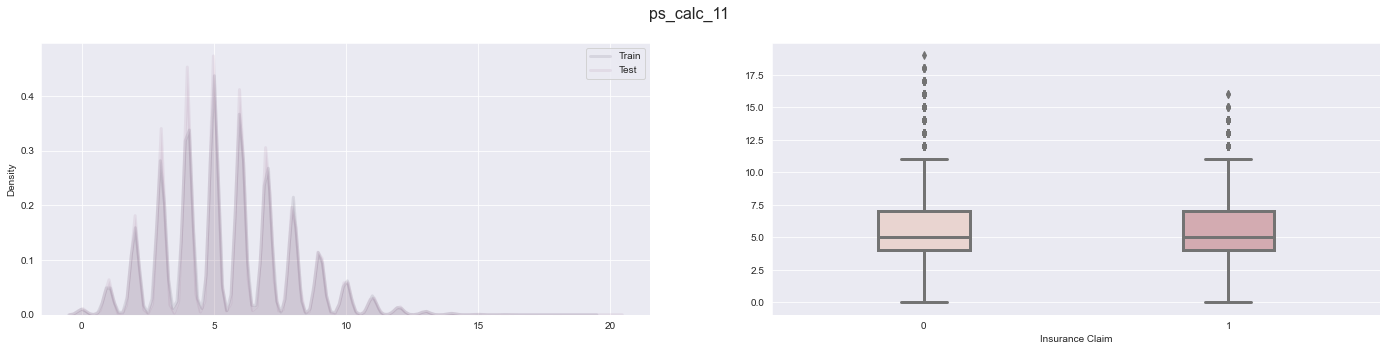

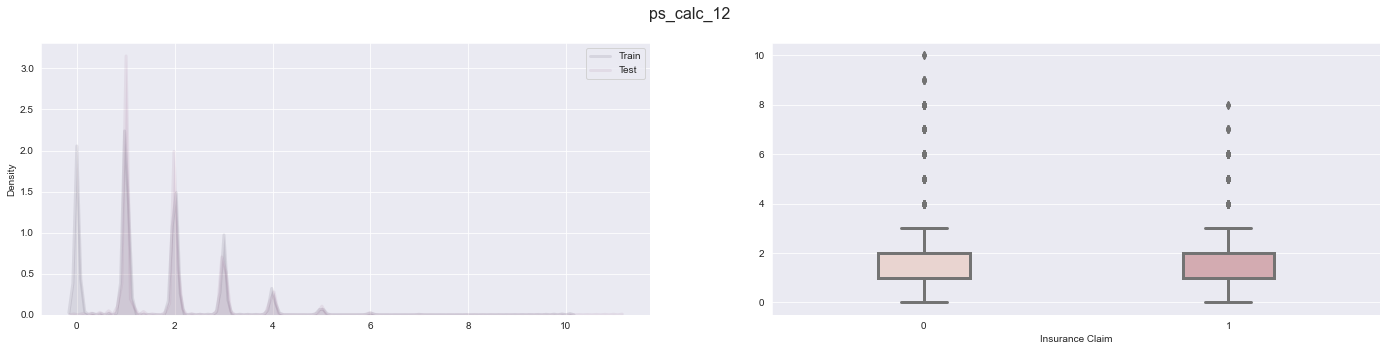

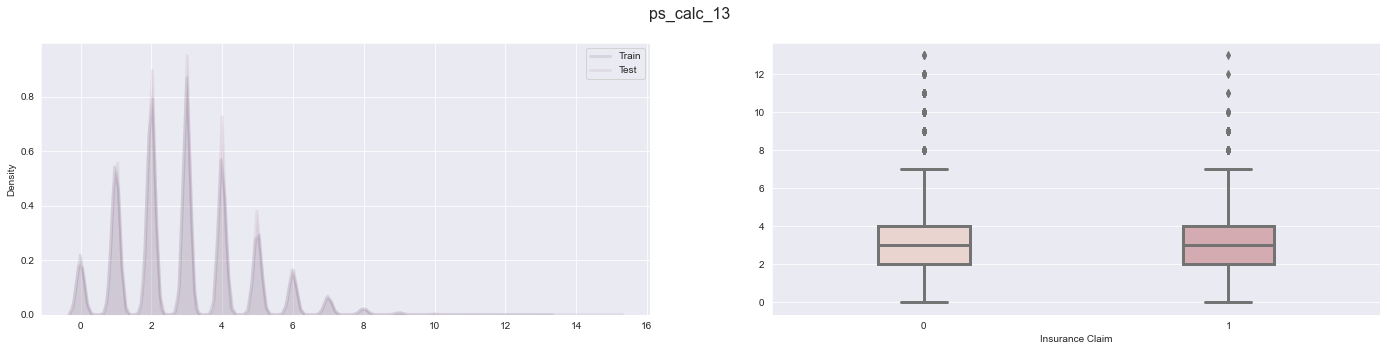

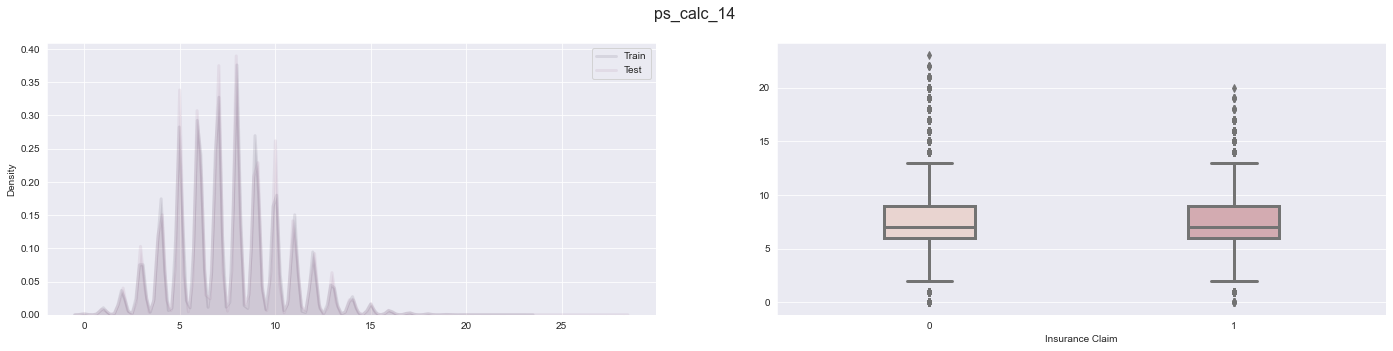

In [34]:
print("CONTINUOUS VARIABLES")
eda_by_vars(cont_vars, train, test, categorical = False)

Checking for the correlations:

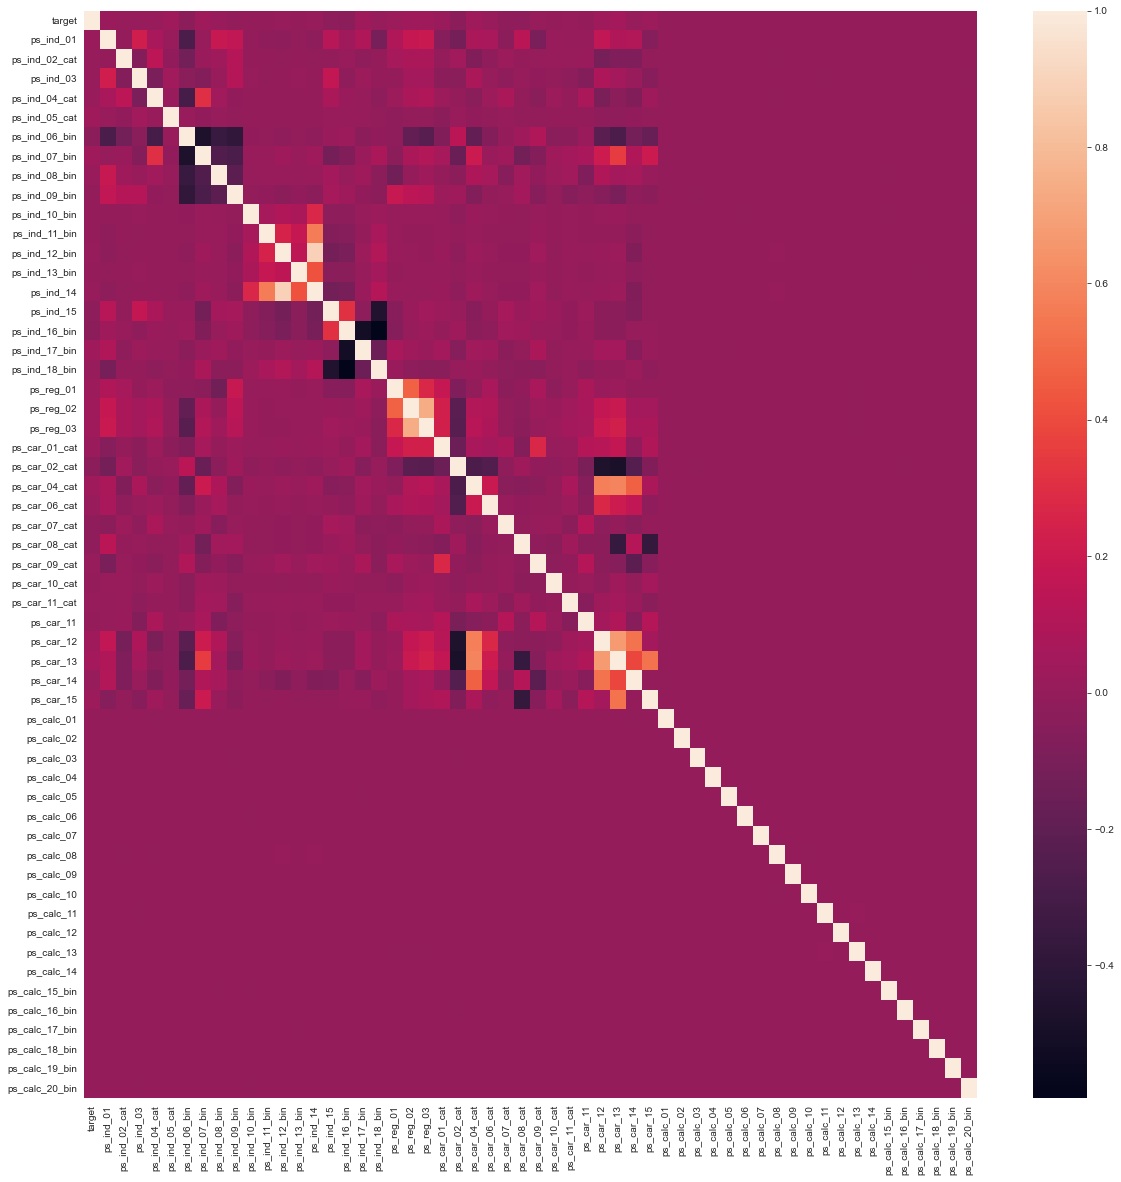

In [35]:
plt.figure(figsize = (20,20))
sns.heatmap(train.corr())

The variables `ps_ind_10_bin`, `ps_ind_11_bin`, `ps_ind_12_bin`, `ps_ind_13_bin` and `ps_ind_14` are being dropped:

In [36]:
train.drop(['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14'], axis=1, inplace=True)
test.drop(['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14'], axis=1, inplace=True)

bin_vars.remove('ps_ind_10_bin')
bin_vars.remove('ps_ind_11_bin')
bin_vars.remove('ps_ind_12_bin')
bin_vars.remove('ps_ind_13_bin')
cont_vars.remove('ps_ind_14')

### Data Preparation:

The major part of data preparation, that is, handling missing values and dropping unnecessary variables, have already been done.

Now, I separate the data into features and target: 

In [37]:
X = train.drop(['target'], axis=1)
y = train['target']
X_test = test.copy()

### Modelling:

Since the given evaluation metric is Gini index, I have created a function to calculate it:

In [38]:
def eval_gini(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_pred)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini

Writing a function for Stratified K-fold CV model training:

In [39]:
def cross_validate(X, y, model):
    
    skf = StratifiedKFold(n_splits = 5,
                          shuffle = True,
                          random_state = 0)
    cv_scores = []
    
    for fold, (train_id, val_id) in enumerate(skf.split(X, y)):
        X_train, X_valid = X.iloc[train_id], X.iloc[val_id]
        y_train, y_valid = y.iloc[train_id], y.iloc[val_id]
        
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_valid)[:, 1]
        gini_score = eval_gini(y_valid, y_pred)
        cv_scores.append(gini_score)
        
        print(f'Fold {fold}: Gini Score = {gini_score}')
        print(f'\n-----------------------------\n')
        
    avg_gini_score = np.mean(cv_scores)
    print(f'Normalized Gini Score: {avg_gini_score}')

**Random Forest Classifier:**

In [40]:
rf_model = RandomForestClassifier(n_estimators = 1500,
                                  max_depth = 9,
                                  max_features = 10,
                                  bootstrap = True,
                                  random_state = 0)
cross_validate(X, y, rf_model)

Fold 0: Gini Score = 0.26806864807507913

-----------------------------

Fold 1: Gini Score = 0.24942699291921366

-----------------------------

Fold 2: Gini Score = 0.24881669488932834

-----------------------------

Fold 3: Gini Score = 0.2819604851526357

-----------------------------

Fold 4: Gini Score = 0.25287085055925784

-----------------------------

Normalized Gini Score: 0.26022873431910293


**Parameters for boosting algorithms:**

In [41]:
boost_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'max_bin': 25,
    'num_leaves': 31,
    'min_child_samples': 1500,
    'colsample_bytree': 0.7,
    'subsample_freq': 1,
    'subsample': 0.7,
    'reg_alpha': 1.0,
    'reg_lambda': 1.0,
    'verbosity': 0,
    'random_state': 0,
    'n_estimators': 1500
}

**XGBoost Classifier:**

In [42]:
xgb_model = XGBClassifier(n_estimators = 1500,
                          learning_rate = 0.01,
                          max_bin = 25,
                          num_leaves = 31,
                          min_child_samples = 1500,
                          colsample_bytree = 0.7,
                          subsample_freq = 1,
                          subsample = 0.7,
                          reg_alpha = 1.0,
                          reg_lambda = 1.0,
                          verbosity = 0,
                          random_state = 0)

cross_validate(X, y, xgb_model)

Fold 0: Gini Score = 0.28690849465145174

-----------------------------

Fold 1: Gini Score = 0.26668931294316

-----------------------------

Fold 2: Gini Score = 0.2709210166769338

-----------------------------

Fold 3: Gini Score = 0.30346595271268606

-----------------------------

Fold 4: Gini Score = 0.2790282432409481

-----------------------------

Normalized Gini Score: 0.281402604045036


**LGBM Classifier:**

In [43]:
lgbm_model = lgbm.LGBMClassifier(**boost_params)

cross_validate(X, y, lgbm_model)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Fold 0: Gini Score = 0.28910497156346926

-----------------------------

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Fold 1: Gini Score = 0.2644539170549134

-----------------------------

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Fold 2: Gini Score = 0.271066708089058

-----------------------------

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075362

**CatBoost Classifier:**

In [44]:
cat_model = catboost.CatBoostClassifier(n_estimators = 1500,
                                        learning_rate = 0.01,
                                        max_bin = 25,
                                        num_leaves = 31,
                                        min_child_samples = 1500,
                                        subsample = 0.7,
                                        reg_lambda = 1.0,
                                        random_state = 0)

cross_validate(X, y, cat_model)

0:	learn: 0.6779402	total: 285ms	remaining: 7m 6s
1:	learn: 0.6632700	total: 446ms	remaining: 5m 34s
2:	learn: 0.6490130	total: 572ms	remaining: 4m 45s
3:	learn: 0.6351548	total: 707ms	remaining: 4m 24s
4:	learn: 0.6215694	total: 811ms	remaining: 4m 2s
5:	learn: 0.6083501	total: 927ms	remaining: 3m 50s
6:	learn: 0.5955441	total: 1.07s	remaining: 3m 48s
7:	learn: 0.5830879	total: 1.21s	remaining: 3m 45s
8:	learn: 0.5710281	total: 1.32s	remaining: 3m 39s
9:	learn: 0.5593133	total: 1.43s	remaining: 3m 32s
10:	learn: 0.5479640	total: 1.55s	remaining: 3m 29s
11:	learn: 0.5369032	total: 1.65s	remaining: 3m 24s
12:	learn: 0.5261249	total: 1.77s	remaining: 3m 22s
13:	learn: 0.5157521	total: 1.86s	remaining: 3m 17s
14:	learn: 0.5056822	total: 1.97s	remaining: 3m 14s
15:	learn: 0.4958081	total: 2.07s	remaining: 3m 12s
16:	learn: 0.4862587	total: 2.19s	remaining: 3m 11s
17:	learn: 0.4770193	total: 2.32s	remaining: 3m 11s
18:	learn: 0.4680588	total: 2.44s	remaining: 3m 10s
19:	learn: 0.4593349	tot

159:	learn: 0.1635529	total: 20.2s	remaining: 2m 49s
160:	learn: 0.1633478	total: 20.4s	remaining: 2m 49s
161:	learn: 0.1631299	total: 20.5s	remaining: 2m 49s
162:	learn: 0.1629278	total: 20.6s	remaining: 2m 49s
163:	learn: 0.1627294	total: 20.8s	remaining: 2m 49s
164:	learn: 0.1625405	total: 20.9s	remaining: 2m 48s
165:	learn: 0.1623467	total: 21s	remaining: 2m 48s
166:	learn: 0.1621693	total: 21.1s	remaining: 2m 48s
167:	learn: 0.1619859	total: 21.2s	remaining: 2m 48s
168:	learn: 0.1618094	total: 21.4s	remaining: 2m 48s
169:	learn: 0.1616442	total: 21.5s	remaining: 2m 48s
170:	learn: 0.1614694	total: 21.6s	remaining: 2m 47s
171:	learn: 0.1612941	total: 21.7s	remaining: 2m 47s
172:	learn: 0.1611273	total: 21.8s	remaining: 2m 47s
173:	learn: 0.1609672	total: 22s	remaining: 2m 47s
174:	learn: 0.1608101	total: 22.1s	remaining: 2m 47s
175:	learn: 0.1606636	total: 22.2s	remaining: 2m 46s
176:	learn: 0.1605045	total: 22.3s	remaining: 2m 46s
177:	learn: 0.1603582	total: 22.5s	remaining: 2m 4

315:	learn: 0.1532313	total: 41.5s	remaining: 2m 35s
316:	learn: 0.1532172	total: 41.6s	remaining: 2m 35s
317:	learn: 0.1532034	total: 41.8s	remaining: 2m 35s
318:	learn: 0.1531924	total: 41.9s	remaining: 2m 35s
319:	learn: 0.1531773	total: 42s	remaining: 2m 34s
320:	learn: 0.1531627	total: 42.2s	remaining: 2m 34s
321:	learn: 0.1531513	total: 42.3s	remaining: 2m 34s
322:	learn: 0.1531372	total: 42.4s	remaining: 2m 34s
323:	learn: 0.1531231	total: 42.6s	remaining: 2m 34s
324:	learn: 0.1531108	total: 42.7s	remaining: 2m 34s
325:	learn: 0.1531006	total: 42.9s	remaining: 2m 34s
326:	learn: 0.1530881	total: 43s	remaining: 2m 34s
327:	learn: 0.1530764	total: 43.1s	remaining: 2m 34s
328:	learn: 0.1530660	total: 43.3s	remaining: 2m 34s
329:	learn: 0.1530536	total: 43.4s	remaining: 2m 33s
330:	learn: 0.1530421	total: 43.5s	remaining: 2m 33s
331:	learn: 0.1530284	total: 43.7s	remaining: 2m 33s
332:	learn: 0.1530184	total: 43.9s	remaining: 2m 33s
333:	learn: 0.1530048	total: 44s	remaining: 2m 33s

471:	learn: 0.1520895	total: 1m	remaining: 2m 12s
472:	learn: 0.1520845	total: 1m	remaining: 2m 12s
473:	learn: 0.1520797	total: 1m 1s	remaining: 2m 12s
474:	learn: 0.1520750	total: 1m 1s	remaining: 2m 11s
475:	learn: 0.1520708	total: 1m 1s	remaining: 2m 11s
476:	learn: 0.1520680	total: 1m 1s	remaining: 2m 11s
477:	learn: 0.1520622	total: 1m 1s	remaining: 2m 11s
478:	learn: 0.1520571	total: 1m 1s	remaining: 2m 11s
479:	learn: 0.1520531	total: 1m 1s	remaining: 2m 11s
480:	learn: 0.1520490	total: 1m 1s	remaining: 2m 11s
481:	learn: 0.1520437	total: 1m 2s	remaining: 2m 10s
482:	learn: 0.1520403	total: 1m 2s	remaining: 2m 10s
483:	learn: 0.1520363	total: 1m 2s	remaining: 2m 10s
484:	learn: 0.1520326	total: 1m 2s	remaining: 2m 10s
485:	learn: 0.1520292	total: 1m 2s	remaining: 2m 10s
486:	learn: 0.1520261	total: 1m 2s	remaining: 2m 10s
487:	learn: 0.1520216	total: 1m 2s	remaining: 2m 10s
488:	learn: 0.1520171	total: 1m 2s	remaining: 2m 10s
489:	learn: 0.1520142	total: 1m 3s	remaining: 2m 10s

626:	learn: 0.1515656	total: 1m 20s	remaining: 1m 52s
627:	learn: 0.1515643	total: 1m 20s	remaining: 1m 52s
628:	learn: 0.1515611	total: 1m 20s	remaining: 1m 52s
629:	learn: 0.1515583	total: 1m 21s	remaining: 1m 52s
630:	learn: 0.1515547	total: 1m 21s	remaining: 1m 51s
631:	learn: 0.1515521	total: 1m 21s	remaining: 1m 51s
632:	learn: 0.1515491	total: 1m 21s	remaining: 1m 51s
633:	learn: 0.1515465	total: 1m 21s	remaining: 1m 51s
634:	learn: 0.1515437	total: 1m 21s	remaining: 1m 51s
635:	learn: 0.1515407	total: 1m 22s	remaining: 1m 51s
636:	learn: 0.1515389	total: 1m 22s	remaining: 1m 51s
637:	learn: 0.1515358	total: 1m 22s	remaining: 1m 51s
638:	learn: 0.1515332	total: 1m 22s	remaining: 1m 51s
639:	learn: 0.1515300	total: 1m 22s	remaining: 1m 50s
640:	learn: 0.1515278	total: 1m 22s	remaining: 1m 50s
641:	learn: 0.1515249	total: 1m 22s	remaining: 1m 50s
642:	learn: 0.1515219	total: 1m 22s	remaining: 1m 50s
643:	learn: 0.1515197	total: 1m 23s	remaining: 1m 50s
644:	learn: 0.1515173	total:

779:	learn: 0.1511859	total: 1m 40s	remaining: 1m 32s
780:	learn: 0.1511838	total: 1m 40s	remaining: 1m 32s
781:	learn: 0.1511815	total: 1m 40s	remaining: 1m 32s
782:	learn: 0.1511793	total: 1m 40s	remaining: 1m 32s
783:	learn: 0.1511768	total: 1m 41s	remaining: 1m 32s
784:	learn: 0.1511740	total: 1m 41s	remaining: 1m 32s
785:	learn: 0.1511717	total: 1m 41s	remaining: 1m 32s
786:	learn: 0.1511692	total: 1m 41s	remaining: 1m 31s
787:	learn: 0.1511668	total: 1m 41s	remaining: 1m 31s
788:	learn: 0.1511658	total: 1m 41s	remaining: 1m 31s
789:	learn: 0.1511631	total: 1m 41s	remaining: 1m 31s
790:	learn: 0.1511608	total: 1m 41s	remaining: 1m 31s
791:	learn: 0.1511581	total: 1m 42s	remaining: 1m 31s
792:	learn: 0.1511560	total: 1m 42s	remaining: 1m 31s
793:	learn: 0.1511531	total: 1m 42s	remaining: 1m 31s
794:	learn: 0.1511508	total: 1m 42s	remaining: 1m 30s
795:	learn: 0.1511484	total: 1m 42s	remaining: 1m 30s
796:	learn: 0.1511466	total: 1m 42s	remaining: 1m 30s
797:	learn: 0.1511435	total:

933:	learn: 0.1508514	total: 2m 3s	remaining: 1m 14s
934:	learn: 0.1508482	total: 2m 3s	remaining: 1m 14s
935:	learn: 0.1508459	total: 2m 3s	remaining: 1m 14s
936:	learn: 0.1508436	total: 2m 3s	remaining: 1m 14s
937:	learn: 0.1508409	total: 2m 3s	remaining: 1m 14s
938:	learn: 0.1508388	total: 2m 3s	remaining: 1m 13s
939:	learn: 0.1508360	total: 2m 3s	remaining: 1m 13s
940:	learn: 0.1508336	total: 2m 3s	remaining: 1m 13s
941:	learn: 0.1508316	total: 2m 4s	remaining: 1m 13s
942:	learn: 0.1508292	total: 2m 4s	remaining: 1m 13s
943:	learn: 0.1508277	total: 2m 4s	remaining: 1m 13s
944:	learn: 0.1508268	total: 2m 4s	remaining: 1m 13s
945:	learn: 0.1508242	total: 2m 4s	remaining: 1m 12s
946:	learn: 0.1508218	total: 2m 4s	remaining: 1m 12s
947:	learn: 0.1508198	total: 2m 4s	remaining: 1m 12s
948:	learn: 0.1508183	total: 2m 4s	remaining: 1m 12s
949:	learn: 0.1508159	total: 2m 5s	remaining: 1m 12s
950:	learn: 0.1508140	total: 2m 5s	remaining: 1m 12s
951:	learn: 0.1508113	total: 2m 5s	remaining: 

1088:	learn: 0.1505340	total: 2m 21s	remaining: 53.5s
1089:	learn: 0.1505318	total: 2m 21s	remaining: 53.3s
1090:	learn: 0.1505307	total: 2m 21s	remaining: 53.2s
1091:	learn: 0.1505286	total: 2m 22s	remaining: 53.1s
1092:	learn: 0.1505267	total: 2m 22s	remaining: 52.9s
1093:	learn: 0.1505251	total: 2m 22s	remaining: 52.8s
1094:	learn: 0.1505228	total: 2m 22s	remaining: 52.7s
1095:	learn: 0.1505204	total: 2m 22s	remaining: 52.5s
1096:	learn: 0.1505182	total: 2m 22s	remaining: 52.4s
1097:	learn: 0.1505160	total: 2m 22s	remaining: 52.2s
1098:	learn: 0.1505139	total: 2m 22s	remaining: 52.1s
1099:	learn: 0.1505120	total: 2m 22s	remaining: 52s
1100:	learn: 0.1505099	total: 2m 23s	remaining: 51.8s
1101:	learn: 0.1505083	total: 2m 23s	remaining: 51.7s
1102:	learn: 0.1505068	total: 2m 23s	remaining: 51.5s
1103:	learn: 0.1505039	total: 2m 23s	remaining: 51.4s
1104:	learn: 0.1505028	total: 2m 23s	remaining: 51.3s
1105:	learn: 0.1505005	total: 2m 23s	remaining: 51.1s
1106:	learn: 0.1504986	total: 

1242:	learn: 0.1502394	total: 2m 41s	remaining: 33.4s
1243:	learn: 0.1502372	total: 2m 41s	remaining: 33.2s
1244:	learn: 0.1502332	total: 2m 41s	remaining: 33.1s
1245:	learn: 0.1502314	total: 2m 41s	remaining: 33s
1246:	learn: 0.1502302	total: 2m 41s	remaining: 32.9s
1247:	learn: 0.1502275	total: 2m 42s	remaining: 32.7s
1248:	learn: 0.1502253	total: 2m 42s	remaining: 32.6s
1249:	learn: 0.1502232	total: 2m 42s	remaining: 32.5s
1250:	learn: 0.1502210	total: 2m 42s	remaining: 32.3s
1251:	learn: 0.1502193	total: 2m 42s	remaining: 32.2s
1252:	learn: 0.1502172	total: 2m 42s	remaining: 32.1s
1253:	learn: 0.1502150	total: 2m 42s	remaining: 31.9s
1254:	learn: 0.1502132	total: 2m 42s	remaining: 31.8s
1255:	learn: 0.1502112	total: 2m 43s	remaining: 31.7s
1256:	learn: 0.1502096	total: 2m 43s	remaining: 31.5s
1257:	learn: 0.1502075	total: 2m 43s	remaining: 31.4s
1258:	learn: 0.1502057	total: 2m 43s	remaining: 31.3s
1259:	learn: 0.1502034	total: 2m 43s	remaining: 31.2s
1260:	learn: 0.1502014	total: 

1397:	learn: 0.1499398	total: 2m 58s	remaining: 13s
1398:	learn: 0.1499380	total: 2m 58s	remaining: 12.9s
1399:	learn: 0.1499362	total: 2m 58s	remaining: 12.8s
1400:	learn: 0.1499342	total: 2m 58s	remaining: 12.6s
1401:	learn: 0.1499319	total: 2m 58s	remaining: 12.5s
1402:	learn: 0.1499294	total: 2m 58s	remaining: 12.4s
1403:	learn: 0.1499275	total: 2m 58s	remaining: 12.2s
1404:	learn: 0.1499254	total: 2m 59s	remaining: 12.1s
1405:	learn: 0.1499233	total: 2m 59s	remaining: 12s
1406:	learn: 0.1499215	total: 2m 59s	remaining: 11.8s
1407:	learn: 0.1499198	total: 2m 59s	remaining: 11.7s
1408:	learn: 0.1499173	total: 2m 59s	remaining: 11.6s
1409:	learn: 0.1499164	total: 2m 59s	remaining: 11.5s
1410:	learn: 0.1499153	total: 2m 59s	remaining: 11.3s
1411:	learn: 0.1499134	total: 2m 59s	remaining: 11.2s
1412:	learn: 0.1499125	total: 2m 59s	remaining: 11.1s
1413:	learn: 0.1499115	total: 2m 59s	remaining: 10.9s
1414:	learn: 0.1499097	total: 2m 59s	remaining: 10.8s
1415:	learn: 0.1499074	total: 2m

53:	learn: 0.2743295	total: 7.09s	remaining: 3m 9s
54:	learn: 0.2712146	total: 7.21s	remaining: 3m 9s
55:	learn: 0.2681380	total: 7.33s	remaining: 3m 8s
56:	learn: 0.2651961	total: 7.46s	remaining: 3m 8s
57:	learn: 0.2622984	total: 7.59s	remaining: 3m 8s
58:	learn: 0.2594994	total: 7.7s	remaining: 3m 8s
59:	learn: 0.2567786	total: 7.83s	remaining: 3m 8s
60:	learn: 0.2541192	total: 7.97s	remaining: 3m 7s
61:	learn: 0.2515212	total: 8.08s	remaining: 3m 7s
62:	learn: 0.2490020	total: 8.2s	remaining: 3m 7s
63:	learn: 0.2465856	total: 8.3s	remaining: 3m 6s
64:	learn: 0.2442379	total: 8.42s	remaining: 3m 5s
65:	learn: 0.2419579	total: 8.54s	remaining: 3m 5s
66:	learn: 0.2397492	total: 8.64s	remaining: 3m 4s
67:	learn: 0.2375570	total: 8.75s	remaining: 3m 4s
68:	learn: 0.2354437	total: 8.87s	remaining: 3m 4s
69:	learn: 0.2333991	total: 8.98s	remaining: 3m 3s
70:	learn: 0.2314043	total: 9.1s	remaining: 3m 3s
71:	learn: 0.2294698	total: 9.21s	remaining: 3m 2s
72:	learn: 0.2275832	total: 9.32s	r

211:	learn: 0.1566674	total: 25.2s	remaining: 2m 32s
212:	learn: 0.1565969	total: 25.3s	remaining: 2m 32s
213:	learn: 0.1565217	total: 25.4s	remaining: 2m 32s
214:	learn: 0.1564502	total: 25.5s	remaining: 2m 32s
215:	learn: 0.1563785	total: 25.6s	remaining: 2m 32s
216:	learn: 0.1563081	total: 25.7s	remaining: 2m 32s
217:	learn: 0.1562365	total: 25.9s	remaining: 2m 32s
218:	learn: 0.1561679	total: 26s	remaining: 2m 31s
219:	learn: 0.1560996	total: 26.1s	remaining: 2m 31s
220:	learn: 0.1560330	total: 26.2s	remaining: 2m 31s
221:	learn: 0.1559748	total: 26.3s	remaining: 2m 31s
222:	learn: 0.1559140	total: 26.4s	remaining: 2m 31s
223:	learn: 0.1558481	total: 26.5s	remaining: 2m 31s
224:	learn: 0.1557949	total: 26.6s	remaining: 2m 30s
225:	learn: 0.1557374	total: 26.7s	remaining: 2m 30s
226:	learn: 0.1556802	total: 26.8s	remaining: 2m 30s
227:	learn: 0.1556264	total: 26.9s	remaining: 2m 30s
228:	learn: 0.1555740	total: 27.1s	remaining: 2m 30s
229:	learn: 0.1555159	total: 27.2s	remaining: 2m

367:	learn: 0.1525095	total: 45.5s	remaining: 2m 19s
368:	learn: 0.1525008	total: 45.6s	remaining: 2m 19s
369:	learn: 0.1524944	total: 45.7s	remaining: 2m 19s
370:	learn: 0.1524859	total: 45.8s	remaining: 2m 19s
371:	learn: 0.1524795	total: 45.9s	remaining: 2m 19s
372:	learn: 0.1524729	total: 46s	remaining: 2m 19s
373:	learn: 0.1524656	total: 46.1s	remaining: 2m 18s
374:	learn: 0.1524577	total: 46.2s	remaining: 2m 18s
375:	learn: 0.1524501	total: 46.3s	remaining: 2m 18s
376:	learn: 0.1524408	total: 46.5s	remaining: 2m 18s
377:	learn: 0.1524325	total: 46.6s	remaining: 2m 18s
378:	learn: 0.1524238	total: 46.7s	remaining: 2m 18s
379:	learn: 0.1524183	total: 46.8s	remaining: 2m 17s
380:	learn: 0.1524113	total: 46.9s	remaining: 2m 17s
381:	learn: 0.1524055	total: 47s	remaining: 2m 17s
382:	learn: 0.1523985	total: 47.1s	remaining: 2m 17s
383:	learn: 0.1523909	total: 47.2s	remaining: 2m 17s
384:	learn: 0.1523840	total: 47.3s	remaining: 2m 17s
385:	learn: 0.1523771	total: 47.4s	remaining: 2m 1

525:	learn: 0.1517115	total: 1m 3s	remaining: 1m 57s
526:	learn: 0.1517078	total: 1m 3s	remaining: 1m 57s
527:	learn: 0.1517044	total: 1m 3s	remaining: 1m 57s
528:	learn: 0.1517008	total: 1m 3s	remaining: 1m 57s
529:	learn: 0.1516968	total: 1m 3s	remaining: 1m 56s
530:	learn: 0.1516940	total: 1m 4s	remaining: 1m 56s
531:	learn: 0.1516906	total: 1m 4s	remaining: 1m 56s
532:	learn: 0.1516877	total: 1m 4s	remaining: 1m 56s
533:	learn: 0.1516842	total: 1m 4s	remaining: 1m 56s
534:	learn: 0.1516806	total: 1m 4s	remaining: 1m 56s
535:	learn: 0.1516787	total: 1m 4s	remaining: 1m 56s
536:	learn: 0.1516770	total: 1m 4s	remaining: 1m 56s
537:	learn: 0.1516741	total: 1m 4s	remaining: 1m 56s
538:	learn: 0.1516704	total: 1m 5s	remaining: 1m 56s
539:	learn: 0.1516665	total: 1m 5s	remaining: 1m 55s
540:	learn: 0.1516635	total: 1m 5s	remaining: 1m 55s
541:	learn: 0.1516580	total: 1m 5s	remaining: 1m 55s
542:	learn: 0.1516545	total: 1m 5s	remaining: 1m 55s
543:	learn: 0.1516514	total: 1m 5s	remaining: 

679:	learn: 0.1512598	total: 1m 23s	remaining: 1m 41s
680:	learn: 0.1512570	total: 1m 24s	remaining: 1m 41s
681:	learn: 0.1512543	total: 1m 24s	remaining: 1m 41s
682:	learn: 0.1512522	total: 1m 24s	remaining: 1m 40s
683:	learn: 0.1512502	total: 1m 24s	remaining: 1m 40s
684:	learn: 0.1512475	total: 1m 24s	remaining: 1m 40s
685:	learn: 0.1512451	total: 1m 24s	remaining: 1m 40s
686:	learn: 0.1512436	total: 1m 24s	remaining: 1m 40s
687:	learn: 0.1512410	total: 1m 25s	remaining: 1m 40s
688:	learn: 0.1512377	total: 1m 25s	remaining: 1m 40s
689:	learn: 0.1512343	total: 1m 25s	remaining: 1m 40s
690:	learn: 0.1512321	total: 1m 25s	remaining: 1m 39s
691:	learn: 0.1512296	total: 1m 25s	remaining: 1m 39s
692:	learn: 0.1512281	total: 1m 25s	remaining: 1m 39s
693:	learn: 0.1512255	total: 1m 25s	remaining: 1m 39s
694:	learn: 0.1512229	total: 1m 25s	remaining: 1m 39s
695:	learn: 0.1512213	total: 1m 25s	remaining: 1m 39s
696:	learn: 0.1512189	total: 1m 25s	remaining: 1m 39s
697:	learn: 0.1512178	total:

831:	learn: 0.1509076	total: 1m 41s	remaining: 1m 21s
832:	learn: 0.1509057	total: 1m 41s	remaining: 1m 21s
833:	learn: 0.1509037	total: 1m 41s	remaining: 1m 21s
834:	learn: 0.1509014	total: 1m 42s	remaining: 1m 21s
835:	learn: 0.1508999	total: 1m 42s	remaining: 1m 21s
836:	learn: 0.1508977	total: 1m 42s	remaining: 1m 21s
837:	learn: 0.1508950	total: 1m 42s	remaining: 1m 21s
838:	learn: 0.1508931	total: 1m 42s	remaining: 1m 20s
839:	learn: 0.1508895	total: 1m 42s	remaining: 1m 20s
840:	learn: 0.1508876	total: 1m 43s	remaining: 1m 20s
841:	learn: 0.1508863	total: 1m 43s	remaining: 1m 20s
842:	learn: 0.1508856	total: 1m 43s	remaining: 1m 20s
843:	learn: 0.1508844	total: 1m 43s	remaining: 1m 20s
844:	learn: 0.1508820	total: 1m 43s	remaining: 1m 20s
845:	learn: 0.1508805	total: 1m 43s	remaining: 1m 20s
846:	learn: 0.1508781	total: 1m 43s	remaining: 1m 20s
847:	learn: 0.1508754	total: 1m 43s	remaining: 1m 19s
848:	learn: 0.1508743	total: 1m 44s	remaining: 1m 19s
849:	learn: 0.1508718	total:

986:	learn: 0.1505911	total: 2m 1s	remaining: 1m 3s
987:	learn: 0.1505893	total: 2m 1s	remaining: 1m 2s
988:	learn: 0.1505880	total: 2m 1s	remaining: 1m 2s
989:	learn: 0.1505858	total: 2m 1s	remaining: 1m 2s
990:	learn: 0.1505846	total: 2m 1s	remaining: 1m 2s
991:	learn: 0.1505817	total: 2m 2s	remaining: 1m 2s
992:	learn: 0.1505799	total: 2m 2s	remaining: 1m 2s
993:	learn: 0.1505773	total: 2m 2s	remaining: 1m 2s
994:	learn: 0.1505756	total: 2m 2s	remaining: 1m 2s
995:	learn: 0.1505733	total: 2m 2s	remaining: 1m 2s
996:	learn: 0.1505714	total: 2m 2s	remaining: 1m 1s
997:	learn: 0.1505695	total: 2m 3s	remaining: 1m 1s
998:	learn: 0.1505670	total: 2m 3s	remaining: 1m 1s
999:	learn: 0.1505650	total: 2m 3s	remaining: 1m 1s
1000:	learn: 0.1505632	total: 2m 3s	remaining: 1m 1s
1001:	learn: 0.1505618	total: 2m 3s	remaining: 1m 1s
1002:	learn: 0.1505608	total: 2m 3s	remaining: 1m 1s
1003:	learn: 0.1505590	total: 2m 4s	remaining: 1m 1s
1004:	learn: 0.1505564	total: 2m 4s	remaining: 1m 1s
1005:	l

1142:	learn: 0.1502844	total: 2m 21s	remaining: 44.2s
1143:	learn: 0.1502829	total: 2m 21s	remaining: 44s
1144:	learn: 0.1502811	total: 2m 21s	remaining: 43.9s
1145:	learn: 0.1502795	total: 2m 21s	remaining: 43.8s
1146:	learn: 0.1502770	total: 2m 21s	remaining: 43.7s
1147:	learn: 0.1502748	total: 2m 21s	remaining: 43.5s
1148:	learn: 0.1502722	total: 2m 22s	remaining: 43.4s
1149:	learn: 0.1502702	total: 2m 22s	remaining: 43.3s
1150:	learn: 0.1502683	total: 2m 22s	remaining: 43.2s
1151:	learn: 0.1502664	total: 2m 22s	remaining: 43s
1152:	learn: 0.1502645	total: 2m 22s	remaining: 42.9s
1153:	learn: 0.1502624	total: 2m 22s	remaining: 42.8s
1154:	learn: 0.1502605	total: 2m 22s	remaining: 42.6s
1155:	learn: 0.1502586	total: 2m 22s	remaining: 42.5s
1156:	learn: 0.1502563	total: 2m 22s	remaining: 42.4s
1157:	learn: 0.1502544	total: 2m 23s	remaining: 42.3s
1158:	learn: 0.1502530	total: 2m 23s	remaining: 42.1s
1159:	learn: 0.1502508	total: 2m 23s	remaining: 42s
1160:	learn: 0.1502487	total: 2m 2

1296:	learn: 0.1499829	total: 2m 44s	remaining: 25.8s
1297:	learn: 0.1499816	total: 2m 45s	remaining: 25.7s
1298:	learn: 0.1499788	total: 2m 45s	remaining: 25.6s
1299:	learn: 0.1499763	total: 2m 45s	remaining: 25.4s
1300:	learn: 0.1499748	total: 2m 45s	remaining: 25.3s
1301:	learn: 0.1499741	total: 2m 45s	remaining: 25.2s
1302:	learn: 0.1499721	total: 2m 45s	remaining: 25.1s
1303:	learn: 0.1499702	total: 2m 45s	remaining: 24.9s
1304:	learn: 0.1499692	total: 2m 46s	remaining: 24.8s
1305:	learn: 0.1499668	total: 2m 46s	remaining: 24.7s
1306:	learn: 0.1499640	total: 2m 46s	remaining: 24.6s
1307:	learn: 0.1499620	total: 2m 46s	remaining: 24.4s
1308:	learn: 0.1499596	total: 2m 46s	remaining: 24.3s
1309:	learn: 0.1499573	total: 2m 46s	remaining: 24.2s
1310:	learn: 0.1499548	total: 2m 46s	remaining: 24s
1311:	learn: 0.1499537	total: 2m 46s	remaining: 23.9s
1312:	learn: 0.1499514	total: 2m 47s	remaining: 23.8s
1313:	learn: 0.1499494	total: 2m 47s	remaining: 23.7s
1314:	learn: 0.1499474	total: 

1450:	learn: 0.1496706	total: 3m 6s	remaining: 6.29s
1451:	learn: 0.1496686	total: 3m 6s	remaining: 6.16s
1452:	learn: 0.1496672	total: 3m 6s	remaining: 6.03s
1453:	learn: 0.1496655	total: 3m 6s	remaining: 5.91s
1454:	learn: 0.1496629	total: 3m 6s	remaining: 5.78s
1455:	learn: 0.1496608	total: 3m 6s	remaining: 5.65s
1456:	learn: 0.1496595	total: 3m 7s	remaining: 5.52s
1457:	learn: 0.1496571	total: 3m 7s	remaining: 5.39s
1458:	learn: 0.1496560	total: 3m 7s	remaining: 5.26s
1459:	learn: 0.1496534	total: 3m 7s	remaining: 5.13s
1460:	learn: 0.1496526	total: 3m 7s	remaining: 5s
1461:	learn: 0.1496508	total: 3m 7s	remaining: 4.88s
1462:	learn: 0.1496475	total: 3m 7s	remaining: 4.75s
1463:	learn: 0.1496449	total: 3m 7s	remaining: 4.62s
1464:	learn: 0.1496427	total: 3m 7s	remaining: 4.49s
1465:	learn: 0.1496403	total: 3m 8s	remaining: 4.36s
1466:	learn: 0.1496378	total: 3m 8s	remaining: 4.23s
1467:	learn: 0.1496358	total: 3m 8s	remaining: 4.1s
1468:	learn: 0.1496338	total: 3m 8s	remaining: 3.9

106:	learn: 0.1860835	total: 12.4s	remaining: 2m 42s
107:	learn: 0.1853345	total: 12.6s	remaining: 2m 41s
108:	learn: 0.1846020	total: 12.7s	remaining: 2m 41s
109:	learn: 0.1838863	total: 12.8s	remaining: 2m 41s
110:	learn: 0.1832056	total: 12.9s	remaining: 2m 41s
111:	learn: 0.1825251	total: 13s	remaining: 2m 40s
112:	learn: 0.1818612	total: 13.1s	remaining: 2m 41s
113:	learn: 0.1812000	total: 13.3s	remaining: 2m 41s
114:	learn: 0.1805809	total: 13.4s	remaining: 2m 40s
115:	learn: 0.1799573	total: 13.5s	remaining: 2m 40s
116:	learn: 0.1793667	total: 13.6s	remaining: 2m 40s
117:	learn: 0.1787936	total: 13.7s	remaining: 2m 40s
118:	learn: 0.1782050	total: 13.8s	remaining: 2m 40s
119:	learn: 0.1776465	total: 13.9s	remaining: 2m 40s
120:	learn: 0.1771217	total: 14s	remaining: 2m 39s
121:	learn: 0.1766047	total: 14.2s	remaining: 2m 39s
122:	learn: 0.1760875	total: 14.3s	remaining: 2m 40s
123:	learn: 0.1755915	total: 14.4s	remaining: 2m 39s
124:	learn: 0.1751093	total: 14.5s	remaining: 2m 3

262:	learn: 0.1542208	total: 29.9s	remaining: 2m 20s
263:	learn: 0.1541926	total: 30s	remaining: 2m 20s
264:	learn: 0.1541675	total: 30.1s	remaining: 2m 20s
265:	learn: 0.1541439	total: 30.2s	remaining: 2m 20s
266:	learn: 0.1541179	total: 30.3s	remaining: 2m 20s
267:	learn: 0.1540897	total: 30.4s	remaining: 2m 19s
268:	learn: 0.1540609	total: 30.5s	remaining: 2m 19s
269:	learn: 0.1540337	total: 30.7s	remaining: 2m 19s
270:	learn: 0.1540104	total: 30.8s	remaining: 2m 19s
271:	learn: 0.1539870	total: 30.9s	remaining: 2m 19s
272:	learn: 0.1539634	total: 31s	remaining: 2m 19s
273:	learn: 0.1539383	total: 31.1s	remaining: 2m 19s
274:	learn: 0.1539155	total: 31.2s	remaining: 2m 19s
275:	learn: 0.1538921	total: 31.3s	remaining: 2m 18s
276:	learn: 0.1538685	total: 31.5s	remaining: 2m 18s
277:	learn: 0.1538416	total: 31.6s	remaining: 2m 18s
278:	learn: 0.1538188	total: 31.7s	remaining: 2m 18s
279:	learn: 0.1537991	total: 31.8s	remaining: 2m 18s
280:	learn: 0.1537744	total: 31.9s	remaining: 2m 1

418:	learn: 0.1522358	total: 50.4s	remaining: 2m 10s
419:	learn: 0.1522292	total: 50.5s	remaining: 2m 9s
420:	learn: 0.1522249	total: 50.7s	remaining: 2m 9s
421:	learn: 0.1522205	total: 50.8s	remaining: 2m 9s
422:	learn: 0.1522146	total: 51s	remaining: 2m 9s
423:	learn: 0.1522079	total: 51.1s	remaining: 2m 9s
424:	learn: 0.1522024	total: 51.2s	remaining: 2m 9s
425:	learn: 0.1521979	total: 51.3s	remaining: 2m 9s
426:	learn: 0.1521922	total: 51.5s	remaining: 2m 9s
427:	learn: 0.1521865	total: 51.6s	remaining: 2m 9s
428:	learn: 0.1521802	total: 51.7s	remaining: 2m 9s
429:	learn: 0.1521740	total: 51.8s	remaining: 2m 8s
430:	learn: 0.1521687	total: 51.9s	remaining: 2m 8s
431:	learn: 0.1521637	total: 52s	remaining: 2m 8s
432:	learn: 0.1521580	total: 52.1s	remaining: 2m 8s
433:	learn: 0.1521522	total: 52.3s	remaining: 2m 8s
434:	learn: 0.1521471	total: 52.4s	remaining: 2m 8s
435:	learn: 0.1521434	total: 52.5s	remaining: 2m 8s
436:	learn: 0.1521380	total: 52.6s	remaining: 2m 8s
437:	learn: 0.1

577:	learn: 0.1516007	total: 1m 11s	remaining: 1m 54s
578:	learn: 0.1515981	total: 1m 12s	remaining: 1m 54s
579:	learn: 0.1515953	total: 1m 12s	remaining: 1m 54s
580:	learn: 0.1515927	total: 1m 12s	remaining: 1m 54s
581:	learn: 0.1515891	total: 1m 12s	remaining: 1m 54s
582:	learn: 0.1515851	total: 1m 12s	remaining: 1m 54s
583:	learn: 0.1515827	total: 1m 12s	remaining: 1m 54s
584:	learn: 0.1515797	total: 1m 12s	remaining: 1m 54s
585:	learn: 0.1515768	total: 1m 13s	remaining: 1m 53s
586:	learn: 0.1515737	total: 1m 13s	remaining: 1m 53s
587:	learn: 0.1515714	total: 1m 13s	remaining: 1m 53s
588:	learn: 0.1515688	total: 1m 13s	remaining: 1m 53s
589:	learn: 0.1515652	total: 1m 13s	remaining: 1m 53s
590:	learn: 0.1515633	total: 1m 13s	remaining: 1m 53s
591:	learn: 0.1515596	total: 1m 13s	remaining: 1m 53s
592:	learn: 0.1515564	total: 1m 14s	remaining: 1m 53s
593:	learn: 0.1515526	total: 1m 14s	remaining: 1m 53s
594:	learn: 0.1515502	total: 1m 14s	remaining: 1m 53s
595:	learn: 0.1515474	total:

729:	learn: 0.1511914	total: 1m 31s	remaining: 1m 36s
730:	learn: 0.1511903	total: 1m 31s	remaining: 1m 36s
731:	learn: 0.1511883	total: 1m 31s	remaining: 1m 36s
732:	learn: 0.1511860	total: 1m 31s	remaining: 1m 36s
733:	learn: 0.1511845	total: 1m 31s	remaining: 1m 35s
734:	learn: 0.1511821	total: 1m 32s	remaining: 1m 35s
735:	learn: 0.1511793	total: 1m 32s	remaining: 1m 35s
736:	learn: 0.1511780	total: 1m 32s	remaining: 1m 35s
737:	learn: 0.1511758	total: 1m 32s	remaining: 1m 35s
738:	learn: 0.1511734	total: 1m 32s	remaining: 1m 35s
739:	learn: 0.1511709	total: 1m 32s	remaining: 1m 35s
740:	learn: 0.1511692	total: 1m 32s	remaining: 1m 35s
741:	learn: 0.1511670	total: 1m 32s	remaining: 1m 34s
742:	learn: 0.1511642	total: 1m 33s	remaining: 1m 34s
743:	learn: 0.1511623	total: 1m 33s	remaining: 1m 34s
744:	learn: 0.1511594	total: 1m 33s	remaining: 1m 34s
745:	learn: 0.1511561	total: 1m 33s	remaining: 1m 34s
746:	learn: 0.1511537	total: 1m 33s	remaining: 1m 34s
747:	learn: 0.1511511	total:

881:	learn: 0.1508517	total: 1m 52s	remaining: 1m 18s
882:	learn: 0.1508503	total: 1m 52s	remaining: 1m 18s
883:	learn: 0.1508480	total: 1m 52s	remaining: 1m 18s
884:	learn: 0.1508460	total: 1m 52s	remaining: 1m 18s
885:	learn: 0.1508438	total: 1m 53s	remaining: 1m 18s
886:	learn: 0.1508416	total: 1m 53s	remaining: 1m 18s
887:	learn: 0.1508387	total: 1m 53s	remaining: 1m 18s
888:	learn: 0.1508366	total: 1m 53s	remaining: 1m 17s
889:	learn: 0.1508344	total: 1m 53s	remaining: 1m 17s
890:	learn: 0.1508326	total: 1m 53s	remaining: 1m 17s
891:	learn: 0.1508300	total: 1m 53s	remaining: 1m 17s
892:	learn: 0.1508285	total: 1m 53s	remaining: 1m 17s
893:	learn: 0.1508260	total: 1m 53s	remaining: 1m 17s
894:	learn: 0.1508230	total: 1m 54s	remaining: 1m 17s
895:	learn: 0.1508213	total: 1m 54s	remaining: 1m 16s
896:	learn: 0.1508193	total: 1m 54s	remaining: 1m 16s
897:	learn: 0.1508174	total: 1m 54s	remaining: 1m 16s
898:	learn: 0.1508156	total: 1m 54s	remaining: 1m 16s
899:	learn: 0.1508139	total:

1037:	learn: 0.1505351	total: 2m 11s	remaining: 58.4s
1038:	learn: 0.1505332	total: 2m 11s	remaining: 58.3s
1039:	learn: 0.1505318	total: 2m 11s	remaining: 58.2s
1040:	learn: 0.1505299	total: 2m 11s	remaining: 58.1s
1041:	learn: 0.1505286	total: 2m 11s	remaining: 57.9s
1042:	learn: 0.1505273	total: 2m 12s	remaining: 57.9s
1043:	learn: 0.1505256	total: 2m 12s	remaining: 57.8s
1044:	learn: 0.1505244	total: 2m 12s	remaining: 57.7s
1045:	learn: 0.1505228	total: 2m 12s	remaining: 57.5s
1046:	learn: 0.1505201	total: 2m 12s	remaining: 57.4s
1047:	learn: 0.1505187	total: 2m 12s	remaining: 57.3s
1048:	learn: 0.1505166	total: 2m 13s	remaining: 57.2s
1049:	learn: 0.1505149	total: 2m 13s	remaining: 57.1s
1050:	learn: 0.1505130	total: 2m 13s	remaining: 57s
1051:	learn: 0.1505108	total: 2m 13s	remaining: 56.9s
1052:	learn: 0.1505093	total: 2m 13s	remaining: 56.8s
1053:	learn: 0.1505070	total: 2m 13s	remaining: 56.6s
1054:	learn: 0.1505046	total: 2m 14s	remaining: 56.5s
1055:	learn: 0.1505033	total: 

1191:	learn: 0.1502533	total: 2m 31s	remaining: 39s
1192:	learn: 0.1502509	total: 2m 31s	remaining: 38.9s
1193:	learn: 0.1502486	total: 2m 31s	remaining: 38.8s
1194:	learn: 0.1502467	total: 2m 31s	remaining: 38.7s
1195:	learn: 0.1502445	total: 2m 31s	remaining: 38.5s
1196:	learn: 0.1502427	total: 2m 31s	remaining: 38.4s
1197:	learn: 0.1502404	total: 2m 31s	remaining: 38.3s
1198:	learn: 0.1502383	total: 2m 31s	remaining: 38.2s
1199:	learn: 0.1502359	total: 2m 32s	remaining: 38s
1200:	learn: 0.1502348	total: 2m 32s	remaining: 37.9s
1201:	learn: 0.1502334	total: 2m 32s	remaining: 37.8s
1202:	learn: 0.1502323	total: 2m 32s	remaining: 37.7s
1203:	learn: 0.1502304	total: 2m 32s	remaining: 37.5s
1204:	learn: 0.1502293	total: 2m 32s	remaining: 37.4s
1205:	learn: 0.1502268	total: 2m 32s	remaining: 37.3s
1206:	learn: 0.1502245	total: 2m 33s	remaining: 37.2s
1207:	learn: 0.1502229	total: 2m 33s	remaining: 37s
1208:	learn: 0.1502220	total: 2m 33s	remaining: 36.9s
1209:	learn: 0.1502199	total: 2m 3

1345:	learn: 0.1499490	total: 2m 52s	remaining: 19.8s
1346:	learn: 0.1499470	total: 2m 52s	remaining: 19.6s
1347:	learn: 0.1499454	total: 2m 53s	remaining: 19.5s
1348:	learn: 0.1499438	total: 2m 53s	remaining: 19.4s
1349:	learn: 0.1499414	total: 2m 53s	remaining: 19.3s
1350:	learn: 0.1499397	total: 2m 53s	remaining: 19.1s
1351:	learn: 0.1499374	total: 2m 53s	remaining: 19s
1352:	learn: 0.1499349	total: 2m 53s	remaining: 18.9s
1353:	learn: 0.1499334	total: 2m 53s	remaining: 18.7s
1354:	learn: 0.1499313	total: 2m 53s	remaining: 18.6s
1355:	learn: 0.1499296	total: 2m 54s	remaining: 18.5s
1356:	learn: 0.1499277	total: 2m 54s	remaining: 18.4s
1357:	learn: 0.1499262	total: 2m 54s	remaining: 18.2s
1358:	learn: 0.1499241	total: 2m 54s	remaining: 18.1s
1359:	learn: 0.1499217	total: 2m 54s	remaining: 18s
1360:	learn: 0.1499187	total: 2m 54s	remaining: 17.8s
1361:	learn: 0.1499168	total: 2m 54s	remaining: 17.7s
1362:	learn: 0.1499149	total: 2m 54s	remaining: 17.6s
1363:	learn: 0.1499134	total: 2m

Fold 2: Gini Score = 0.2668526220772406

-----------------------------

0:	learn: 0.6779501	total: 166ms	remaining: 4m 8s
1:	learn: 0.6632629	total: 292ms	remaining: 3m 38s
2:	learn: 0.6490086	total: 403ms	remaining: 3m 21s
3:	learn: 0.6350822	total: 541ms	remaining: 3m 22s
4:	learn: 0.6215030	total: 679ms	remaining: 3m 22s
5:	learn: 0.6082854	total: 801ms	remaining: 3m 19s
6:	learn: 0.5954951	total: 932ms	remaining: 3m 18s
7:	learn: 0.5830450	total: 1.08s	remaining: 3m 21s
8:	learn: 0.5709855	total: 1.22s	remaining: 3m 22s
9:	learn: 0.5592613	total: 1.35s	remaining: 3m 20s
10:	learn: 0.5479155	total: 1.48s	remaining: 3m 20s
11:	learn: 0.5368532	total: 1.61s	remaining: 3m 20s
12:	learn: 0.5260760	total: 1.73s	remaining: 3m 18s
13:	learn: 0.5156829	total: 1.85s	remaining: 3m 16s
14:	learn: 0.5055600	total: 1.97s	remaining: 3m 15s
15:	learn: 0.4957591	total: 2.12s	remaining: 3m 16s
16:	learn: 0.4861786	total: 2.25s	remaining: 3m 16s
17:	learn: 0.4769307	total: 2.39s	remaining: 3m 16s
18:

158:	learn: 0.1638235	total: 19.2s	remaining: 2m 42s
159:	learn: 0.1636036	total: 19.3s	remaining: 2m 41s
160:	learn: 0.1633860	total: 19.4s	remaining: 2m 41s
161:	learn: 0.1631641	total: 19.6s	remaining: 2m 41s
162:	learn: 0.1629686	total: 19.7s	remaining: 2m 41s
163:	learn: 0.1627651	total: 19.8s	remaining: 2m 41s
164:	learn: 0.1625566	total: 19.9s	remaining: 2m 41s
165:	learn: 0.1623717	total: 20.1s	remaining: 2m 41s
166:	learn: 0.1621785	total: 20.2s	remaining: 2m 41s
167:	learn: 0.1619886	total: 20.3s	remaining: 2m 40s
168:	learn: 0.1618089	total: 20.4s	remaining: 2m 40s
169:	learn: 0.1616350	total: 20.5s	remaining: 2m 40s
170:	learn: 0.1614575	total: 20.6s	remaining: 2m 40s
171:	learn: 0.1612989	total: 20.7s	remaining: 2m 40s
172:	learn: 0.1611337	total: 20.9s	remaining: 2m 40s
173:	learn: 0.1609861	total: 21s	remaining: 2m 39s
174:	learn: 0.1608216	total: 21.1s	remaining: 2m 39s
175:	learn: 0.1606717	total: 21.2s	remaining: 2m 39s
176:	learn: 0.1605209	total: 21.4s	remaining: 2m

315:	learn: 0.1533178	total: 40.3s	remaining: 2m 31s
316:	learn: 0.1533047	total: 40.4s	remaining: 2m 30s
317:	learn: 0.1532917	total: 40.6s	remaining: 2m 30s
318:	learn: 0.1532777	total: 40.7s	remaining: 2m 30s
319:	learn: 0.1532628	total: 40.8s	remaining: 2m 30s
320:	learn: 0.1532497	total: 40.9s	remaining: 2m 30s
321:	learn: 0.1532376	total: 41s	remaining: 2m 30s
322:	learn: 0.1532221	total: 41.1s	remaining: 2m 29s
323:	learn: 0.1532071	total: 41.3s	remaining: 2m 29s
324:	learn: 0.1531944	total: 41.4s	remaining: 2m 29s
325:	learn: 0.1531817	total: 41.5s	remaining: 2m 29s
326:	learn: 0.1531690	total: 41.6s	remaining: 2m 29s
327:	learn: 0.1531567	total: 41.7s	remaining: 2m 29s
328:	learn: 0.1531442	total: 41.9s	remaining: 2m 29s
329:	learn: 0.1531349	total: 42s	remaining: 2m 28s
330:	learn: 0.1531247	total: 42.1s	remaining: 2m 28s
331:	learn: 0.1531136	total: 42.2s	remaining: 2m 28s
332:	learn: 0.1531037	total: 42.4s	remaining: 2m 28s
333:	learn: 0.1530959	total: 42.5s	remaining: 2m 2

471:	learn: 0.1521751	total: 59.5s	remaining: 2m 9s
472:	learn: 0.1521708	total: 59.6s	remaining: 2m 9s
473:	learn: 0.1521671	total: 59.7s	remaining: 2m 9s
474:	learn: 0.1521631	total: 59.8s	remaining: 2m 9s
475:	learn: 0.1521593	total: 60s	remaining: 2m 8s
476:	learn: 0.1521553	total: 1m	remaining: 2m 8s
477:	learn: 0.1521525	total: 1m	remaining: 2m 8s
478:	learn: 0.1521481	total: 1m	remaining: 2m 8s
479:	learn: 0.1521452	total: 1m	remaining: 2m 8s
480:	learn: 0.1521420	total: 1m	remaining: 2m 8s
481:	learn: 0.1521380	total: 1m	remaining: 2m 8s
482:	learn: 0.1521338	total: 1m	remaining: 2m 7s
483:	learn: 0.1521293	total: 1m	remaining: 2m 7s
484:	learn: 0.1521270	total: 1m 1s	remaining: 2m 7s
485:	learn: 0.1521222	total: 1m 1s	remaining: 2m 7s
486:	learn: 0.1521177	total: 1m 1s	remaining: 2m 7s
487:	learn: 0.1521142	total: 1m 1s	remaining: 2m 7s
488:	learn: 0.1521097	total: 1m 1s	remaining: 2m 7s
489:	learn: 0.1521063	total: 1m 1s	remaining: 2m 7s
490:	learn: 0.1521027	total: 1m 1s	rem

627:	learn: 0.1516687	total: 1m 20s	remaining: 1m 51s
628:	learn: 0.1516665	total: 1m 20s	remaining: 1m 51s
629:	learn: 0.1516640	total: 1m 20s	remaining: 1m 51s
630:	learn: 0.1516614	total: 1m 21s	remaining: 1m 51s
631:	learn: 0.1516589	total: 1m 21s	remaining: 1m 51s
632:	learn: 0.1516548	total: 1m 21s	remaining: 1m 51s
633:	learn: 0.1516519	total: 1m 21s	remaining: 1m 51s
634:	learn: 0.1516488	total: 1m 21s	remaining: 1m 51s
635:	learn: 0.1516471	total: 1m 22s	remaining: 1m 51s
636:	learn: 0.1516442	total: 1m 22s	remaining: 1m 51s
637:	learn: 0.1516421	total: 1m 22s	remaining: 1m 51s
638:	learn: 0.1516410	total: 1m 22s	remaining: 1m 51s
639:	learn: 0.1516381	total: 1m 22s	remaining: 1m 51s
640:	learn: 0.1516347	total: 1m 22s	remaining: 1m 51s
641:	learn: 0.1516322	total: 1m 23s	remaining: 1m 50s
642:	learn: 0.1516294	total: 1m 23s	remaining: 1m 50s
643:	learn: 0.1516269	total: 1m 23s	remaining: 1m 50s
644:	learn: 0.1516245	total: 1m 23s	remaining: 1m 50s
645:	learn: 0.1516222	total:

779:	learn: 0.1513010	total: 1m 43s	remaining: 1m 35s
780:	learn: 0.1512988	total: 1m 43s	remaining: 1m 35s
781:	learn: 0.1512966	total: 1m 43s	remaining: 1m 34s
782:	learn: 0.1512939	total: 1m 43s	remaining: 1m 34s
783:	learn: 0.1512921	total: 1m 43s	remaining: 1m 34s
784:	learn: 0.1512901	total: 1m 43s	remaining: 1m 34s
785:	learn: 0.1512874	total: 1m 43s	remaining: 1m 34s
786:	learn: 0.1512857	total: 1m 44s	remaining: 1m 34s
787:	learn: 0.1512830	total: 1m 44s	remaining: 1m 34s
788:	learn: 0.1512812	total: 1m 44s	remaining: 1m 33s
789:	learn: 0.1512792	total: 1m 44s	remaining: 1m 33s
790:	learn: 0.1512772	total: 1m 44s	remaining: 1m 33s
791:	learn: 0.1512747	total: 1m 44s	remaining: 1m 33s
792:	learn: 0.1512725	total: 1m 44s	remaining: 1m 33s
793:	learn: 0.1512701	total: 1m 44s	remaining: 1m 33s
794:	learn: 0.1512689	total: 1m 45s	remaining: 1m 33s
795:	learn: 0.1512664	total: 1m 45s	remaining: 1m 33s
796:	learn: 0.1512638	total: 1m 45s	remaining: 1m 32s
797:	learn: 0.1512614	total:

933:	learn: 0.1509844	total: 2m 4s	remaining: 1m 15s
934:	learn: 0.1509824	total: 2m 4s	remaining: 1m 15s
935:	learn: 0.1509794	total: 2m 4s	remaining: 1m 15s
936:	learn: 0.1509774	total: 2m 4s	remaining: 1m 14s
937:	learn: 0.1509757	total: 2m 4s	remaining: 1m 14s
938:	learn: 0.1509748	total: 2m 4s	remaining: 1m 14s
939:	learn: 0.1509734	total: 2m 5s	remaining: 1m 14s
940:	learn: 0.1509707	total: 2m 5s	remaining: 1m 14s
941:	learn: 0.1509684	total: 2m 5s	remaining: 1m 14s
942:	learn: 0.1509663	total: 2m 5s	remaining: 1m 14s
943:	learn: 0.1509629	total: 2m 5s	remaining: 1m 13s
944:	learn: 0.1509612	total: 2m 5s	remaining: 1m 13s
945:	learn: 0.1509592	total: 2m 5s	remaining: 1m 13s
946:	learn: 0.1509577	total: 2m 5s	remaining: 1m 13s
947:	learn: 0.1509556	total: 2m 6s	remaining: 1m 13s
948:	learn: 0.1509532	total: 2m 6s	remaining: 1m 13s
949:	learn: 0.1509500	total: 2m 6s	remaining: 1m 13s
950:	learn: 0.1509484	total: 2m 6s	remaining: 1m 13s
951:	learn: 0.1509474	total: 2m 6s	remaining: 

1087:	learn: 0.1506899	total: 2m 22s	remaining: 54.1s
1088:	learn: 0.1506877	total: 2m 22s	remaining: 53.9s
1089:	learn: 0.1506858	total: 2m 23s	remaining: 53.8s
1090:	learn: 0.1506834	total: 2m 23s	remaining: 53.7s
1091:	learn: 0.1506822	total: 2m 23s	remaining: 53.5s
1092:	learn: 0.1506803	total: 2m 23s	remaining: 53.4s
1093:	learn: 0.1506784	total: 2m 23s	remaining: 53.3s
1094:	learn: 0.1506770	total: 2m 23s	remaining: 53.1s
1095:	learn: 0.1506749	total: 2m 23s	remaining: 53s
1096:	learn: 0.1506732	total: 2m 23s	remaining: 52.9s
1097:	learn: 0.1506716	total: 2m 24s	remaining: 52.7s
1098:	learn: 0.1506701	total: 2m 24s	remaining: 52.6s
1099:	learn: 0.1506687	total: 2m 24s	remaining: 52.5s
1100:	learn: 0.1506677	total: 2m 24s	remaining: 52.3s
1101:	learn: 0.1506657	total: 2m 24s	remaining: 52.2s
1102:	learn: 0.1506639	total: 2m 24s	remaining: 52.1s
1103:	learn: 0.1506620	total: 2m 24s	remaining: 51.9s
1104:	learn: 0.1506595	total: 2m 24s	remaining: 51.8s
1105:	learn: 0.1506576	total: 

1241:	learn: 0.1504073	total: 2m 43s	remaining: 33.9s
1242:	learn: 0.1504058	total: 2m 43s	remaining: 33.7s
1243:	learn: 0.1504037	total: 2m 43s	remaining: 33.6s
1244:	learn: 0.1504014	total: 2m 43s	remaining: 33.5s
1245:	learn: 0.1504007	total: 2m 43s	remaining: 33.4s
1246:	learn: 0.1503985	total: 2m 43s	remaining: 33.2s
1247:	learn: 0.1503947	total: 2m 43s	remaining: 33.1s
1248:	learn: 0.1503932	total: 2m 44s	remaining: 33s
1249:	learn: 0.1503912	total: 2m 44s	remaining: 32.8s
1250:	learn: 0.1503900	total: 2m 44s	remaining: 32.7s
1251:	learn: 0.1503887	total: 2m 44s	remaining: 32.6s
1252:	learn: 0.1503865	total: 2m 44s	remaining: 32.4s
1253:	learn: 0.1503853	total: 2m 44s	remaining: 32.3s
1254:	learn: 0.1503828	total: 2m 44s	remaining: 32.2s
1255:	learn: 0.1503803	total: 2m 44s	remaining: 32s
1256:	learn: 0.1503786	total: 2m 44s	remaining: 31.9s
1257:	learn: 0.1503770	total: 2m 45s	remaining: 31.7s
1258:	learn: 0.1503750	total: 2m 45s	remaining: 31.6s
1259:	learn: 0.1503726	total: 2m

1395:	learn: 0.1501167	total: 3m 6s	remaining: 13.9s
1396:	learn: 0.1501150	total: 3m 6s	remaining: 13.8s
1397:	learn: 0.1501131	total: 3m 6s	remaining: 13.6s
1398:	learn: 0.1501111	total: 3m 6s	remaining: 13.5s
1399:	learn: 0.1501089	total: 3m 6s	remaining: 13.4s
1400:	learn: 0.1501079	total: 3m 7s	remaining: 13.2s
1401:	learn: 0.1501068	total: 3m 7s	remaining: 13.1s
1402:	learn: 0.1501051	total: 3m 7s	remaining: 12.9s
1403:	learn: 0.1501017	total: 3m 7s	remaining: 12.8s
1404:	learn: 0.1500995	total: 3m 7s	remaining: 12.7s
1405:	learn: 0.1500984	total: 3m 7s	remaining: 12.6s
1406:	learn: 0.1500969	total: 3m 7s	remaining: 12.4s
1407:	learn: 0.1500949	total: 3m 7s	remaining: 12.3s
1408:	learn: 0.1500929	total: 3m 8s	remaining: 12.1s
1409:	learn: 0.1500921	total: 3m 8s	remaining: 12s
1410:	learn: 0.1500896	total: 3m 8s	remaining: 11.9s
1411:	learn: 0.1500876	total: 3m 8s	remaining: 11.7s
1412:	learn: 0.1500870	total: 3m 8s	remaining: 11.6s
1413:	learn: 0.1500847	total: 3m 8s	remaining: 1

50:	learn: 0.2842800	total: 6.28s	remaining: 2m 58s
51:	learn: 0.2808988	total: 6.35s	remaining: 2m 56s
52:	learn: 0.2775885	total: 6.45s	remaining: 2m 56s
53:	learn: 0.2743666	total: 6.58s	remaining: 2m 56s
54:	learn: 0.2712392	total: 6.7s	remaining: 2m 56s
55:	learn: 0.2682154	total: 6.82s	remaining: 2m 55s
56:	learn: 0.2652185	total: 6.95s	remaining: 2m 55s
57:	learn: 0.2622979	total: 7.08s	remaining: 2m 55s
58:	learn: 0.2595042	total: 7.22s	remaining: 2m 56s
59:	learn: 0.2568057	total: 7.37s	remaining: 2m 56s
60:	learn: 0.2541623	total: 7.51s	remaining: 2m 57s
61:	learn: 0.2515773	total: 7.66s	remaining: 2m 57s
62:	learn: 0.2491053	total: 7.89s	remaining: 2m 59s
63:	learn: 0.2466736	total: 8.1s	remaining: 3m 1s
64:	learn: 0.2442901	total: 8.25s	remaining: 3m 2s
65:	learn: 0.2419963	total: 8.42s	remaining: 3m 2s
66:	learn: 0.2397714	total: 8.58s	remaining: 3m 3s
67:	learn: 0.2376276	total: 8.75s	remaining: 3m 4s
68:	learn: 0.2355217	total: 9.22s	remaining: 3m 11s
69:	learn: 0.233469

208:	learn: 0.1568942	total: 33.2s	remaining: 3m 25s
209:	learn: 0.1568182	total: 33.3s	remaining: 3m 24s
210:	learn: 0.1567446	total: 33.5s	remaining: 3m 24s
211:	learn: 0.1566695	total: 33.6s	remaining: 3m 24s
212:	learn: 0.1566019	total: 33.7s	remaining: 3m 23s
213:	learn: 0.1565222	total: 33.9s	remaining: 3m 23s
214:	learn: 0.1564522	total: 34s	remaining: 3m 23s
215:	learn: 0.1563835	total: 34.2s	remaining: 3m 23s
216:	learn: 0.1563167	total: 34.3s	remaining: 3m 22s
217:	learn: 0.1562532	total: 34.4s	remaining: 3m 22s
218:	learn: 0.1561927	total: 34.6s	remaining: 3m 22s
219:	learn: 0.1561347	total: 34.8s	remaining: 3m 22s
220:	learn: 0.1560679	total: 35s	remaining: 3m 22s
221:	learn: 0.1560123	total: 35.1s	remaining: 3m 22s
222:	learn: 0.1559535	total: 35.2s	remaining: 3m 21s
223:	learn: 0.1558950	total: 35.4s	remaining: 3m 21s
224:	learn: 0.1558316	total: 35.5s	remaining: 3m 21s
225:	learn: 0.1557763	total: 35.6s	remaining: 3m 20s
226:	learn: 0.1557197	total: 35.7s	remaining: 3m 2

364:	learn: 0.1526438	total: 59.2s	remaining: 3m 4s
365:	learn: 0.1526345	total: 59.3s	remaining: 3m 3s
366:	learn: 0.1526271	total: 59.5s	remaining: 3m 3s
367:	learn: 0.1526202	total: 59.6s	remaining: 3m 3s
368:	learn: 0.1526122	total: 59.8s	remaining: 3m 3s
369:	learn: 0.1526036	total: 59.9s	remaining: 3m 3s
370:	learn: 0.1525977	total: 1m	remaining: 3m 2s
371:	learn: 0.1525894	total: 1m	remaining: 3m 2s
372:	learn: 0.1525807	total: 1m	remaining: 3m 2s
373:	learn: 0.1525746	total: 1m	remaining: 3m 2s
374:	learn: 0.1525673	total: 1m	remaining: 3m 1s
375:	learn: 0.1525581	total: 1m	remaining: 3m 1s
376:	learn: 0.1525494	total: 1m	remaining: 3m 1s
377:	learn: 0.1525394	total: 1m 1s	remaining: 3m 1s
378:	learn: 0.1525308	total: 1m 1s	remaining: 3m
379:	learn: 0.1525227	total: 1m 1s	remaining: 3m
380:	learn: 0.1525174	total: 1m 1s	remaining: 3m
381:	learn: 0.1525112	total: 1m 1s	remaining: 3m
382:	learn: 0.1525020	total: 1m 1s	remaining: 3m
383:	learn: 0.1524949	total: 1m 1s	remaining: 2m

519:	learn: 0.1518284	total: 1m 23s	remaining: 2m 36s
520:	learn: 0.1518256	total: 1m 23s	remaining: 2m 36s
521:	learn: 0.1518215	total: 1m 23s	remaining: 2m 36s
522:	learn: 0.1518178	total: 1m 23s	remaining: 2m 36s
523:	learn: 0.1518133	total: 1m 23s	remaining: 2m 35s
524:	learn: 0.1518098	total: 1m 23s	remaining: 2m 35s
525:	learn: 0.1518069	total: 1m 24s	remaining: 2m 35s
526:	learn: 0.1518045	total: 1m 24s	remaining: 2m 35s
527:	learn: 0.1518007	total: 1m 24s	remaining: 2m 35s
528:	learn: 0.1517970	total: 1m 24s	remaining: 2m 34s
529:	learn: 0.1517932	total: 1m 24s	remaining: 2m 34s
530:	learn: 0.1517892	total: 1m 24s	remaining: 2m 34s
531:	learn: 0.1517865	total: 1m 24s	remaining: 2m 34s
532:	learn: 0.1517828	total: 1m 25s	remaining: 2m 34s
533:	learn: 0.1517790	total: 1m 25s	remaining: 2m 34s
534:	learn: 0.1517754	total: 1m 25s	remaining: 2m 33s
535:	learn: 0.1517722	total: 1m 25s	remaining: 2m 33s
536:	learn: 0.1517692	total: 1m 25s	remaining: 2m 33s
537:	learn: 0.1517656	total:

671:	learn: 0.1513890	total: 1m 44s	remaining: 2m 8s
672:	learn: 0.1513847	total: 1m 44s	remaining: 2m 8s
673:	learn: 0.1513820	total: 1m 44s	remaining: 2m 8s
674:	learn: 0.1513793	total: 1m 44s	remaining: 2m 8s
675:	learn: 0.1513770	total: 1m 45s	remaining: 2m 8s
676:	learn: 0.1513755	total: 1m 45s	remaining: 2m 7s
677:	learn: 0.1513737	total: 1m 45s	remaining: 2m 7s
678:	learn: 0.1513723	total: 1m 45s	remaining: 2m 7s
679:	learn: 0.1513700	total: 1m 45s	remaining: 2m 7s
680:	learn: 0.1513669	total: 1m 45s	remaining: 2m 7s
681:	learn: 0.1513644	total: 1m 45s	remaining: 2m 6s
682:	learn: 0.1513621	total: 1m 45s	remaining: 2m 6s
683:	learn: 0.1513596	total: 1m 46s	remaining: 2m 6s
684:	learn: 0.1513564	total: 1m 46s	remaining: 2m 6s
685:	learn: 0.1513539	total: 1m 46s	remaining: 2m 6s
686:	learn: 0.1513515	total: 1m 46s	remaining: 2m 5s
687:	learn: 0.1513490	total: 1m 46s	remaining: 2m 5s
688:	learn: 0.1513462	total: 1m 46s	remaining: 2m 5s
689:	learn: 0.1513432	total: 1m 46s	remaining:

825:	learn: 0.1510246	total: 2m 3s	remaining: 1m 40s
826:	learn: 0.1510228	total: 2m 3s	remaining: 1m 40s
827:	learn: 0.1510200	total: 2m 3s	remaining: 1m 40s
828:	learn: 0.1510186	total: 2m 4s	remaining: 1m 40s
829:	learn: 0.1510166	total: 2m 4s	remaining: 1m 40s
830:	learn: 0.1510139	total: 2m 4s	remaining: 1m 40s
831:	learn: 0.1510123	total: 2m 4s	remaining: 1m 39s
832:	learn: 0.1510094	total: 2m 4s	remaining: 1m 39s
833:	learn: 0.1510072	total: 2m 4s	remaining: 1m 39s
834:	learn: 0.1510049	total: 2m 4s	remaining: 1m 39s
835:	learn: 0.1510029	total: 2m 5s	remaining: 1m 39s
836:	learn: 0.1510010	total: 2m 5s	remaining: 1m 39s
837:	learn: 0.1509982	total: 2m 5s	remaining: 1m 38s
838:	learn: 0.1509962	total: 2m 5s	remaining: 1m 38s
839:	learn: 0.1509942	total: 2m 5s	remaining: 1m 38s
840:	learn: 0.1509923	total: 2m 5s	remaining: 1m 38s
841:	learn: 0.1509896	total: 2m 5s	remaining: 1m 38s
842:	learn: 0.1509874	total: 2m 5s	remaining: 1m 38s
843:	learn: 0.1509855	total: 2m 5s	remaining: 

978:	learn: 0.1507215	total: 2m 24s	remaining: 1m 17s
979:	learn: 0.1507191	total: 2m 24s	remaining: 1m 16s
980:	learn: 0.1507176	total: 2m 24s	remaining: 1m 16s
981:	learn: 0.1507154	total: 2m 25s	remaining: 1m 16s
982:	learn: 0.1507138	total: 2m 25s	remaining: 1m 16s
983:	learn: 0.1507114	total: 2m 25s	remaining: 1m 16s
984:	learn: 0.1507106	total: 2m 25s	remaining: 1m 16s
985:	learn: 0.1507084	total: 2m 25s	remaining: 1m 15s
986:	learn: 0.1507061	total: 2m 25s	remaining: 1m 15s
987:	learn: 0.1507041	total: 2m 25s	remaining: 1m 15s
988:	learn: 0.1507025	total: 2m 26s	remaining: 1m 15s
989:	learn: 0.1507004	total: 2m 26s	remaining: 1m 15s
990:	learn: 0.1506988	total: 2m 26s	remaining: 1m 15s
991:	learn: 0.1506972	total: 2m 26s	remaining: 1m 14s
992:	learn: 0.1506949	total: 2m 26s	remaining: 1m 14s
993:	learn: 0.1506910	total: 2m 26s	remaining: 1m 14s
994:	learn: 0.1506891	total: 2m 26s	remaining: 1m 14s
995:	learn: 0.1506875	total: 2m 26s	remaining: 1m 14s
996:	learn: 0.1506855	total:

1131:	learn: 0.1504231	total: 2m 43s	remaining: 53.3s
1132:	learn: 0.1504220	total: 2m 44s	remaining: 53.1s
1133:	learn: 0.1504205	total: 2m 44s	remaining: 53s
1134:	learn: 0.1504189	total: 2m 44s	remaining: 52.8s
1135:	learn: 0.1504174	total: 2m 44s	remaining: 52.7s
1136:	learn: 0.1504155	total: 2m 44s	remaining: 52.5s
1137:	learn: 0.1504134	total: 2m 44s	remaining: 52.4s
1138:	learn: 0.1504116	total: 2m 44s	remaining: 52.2s
1139:	learn: 0.1504100	total: 2m 44s	remaining: 52.1s
1140:	learn: 0.1504090	total: 2m 44s	remaining: 51.9s
1141:	learn: 0.1504079	total: 2m 45s	remaining: 51.7s
1142:	learn: 0.1504068	total: 2m 45s	remaining: 51.6s
1143:	learn: 0.1504053	total: 2m 45s	remaining: 51.4s
1144:	learn: 0.1504036	total: 2m 45s	remaining: 51.3s
1145:	learn: 0.1504012	total: 2m 45s	remaining: 51.1s
1146:	learn: 0.1503992	total: 2m 45s	remaining: 51s
1147:	learn: 0.1503967	total: 2m 45s	remaining: 50.8s
1148:	learn: 0.1503940	total: 2m 45s	remaining: 50.7s
1149:	learn: 0.1503917	total: 2m

1286:	learn: 0.1501322	total: 3m 3s	remaining: 30.3s
1287:	learn: 0.1501307	total: 3m 3s	remaining: 30.2s
1288:	learn: 0.1501287	total: 3m 3s	remaining: 30s
1289:	learn: 0.1501273	total: 3m 3s	remaining: 29.9s
1290:	learn: 0.1501254	total: 3m 3s	remaining: 29.7s
1291:	learn: 0.1501240	total: 3m 3s	remaining: 29.6s
1292:	learn: 0.1501221	total: 3m 3s	remaining: 29.5s
1293:	learn: 0.1501208	total: 3m 4s	remaining: 29.3s
1294:	learn: 0.1501187	total: 3m 4s	remaining: 29.2s
1295:	learn: 0.1501163	total: 3m 4s	remaining: 29s
1296:	learn: 0.1501126	total: 3m 4s	remaining: 28.9s
1297:	learn: 0.1501112	total: 3m 4s	remaining: 28.7s
1298:	learn: 0.1501103	total: 3m 4s	remaining: 28.6s
1299:	learn: 0.1501075	total: 3m 4s	remaining: 28.4s
1300:	learn: 0.1501051	total: 3m 5s	remaining: 28.3s
1301:	learn: 0.1501040	total: 3m 5s	remaining: 28.2s
1302:	learn: 0.1501017	total: 3m 5s	remaining: 28s
1303:	learn: 0.1500995	total: 3m 5s	remaining: 27.9s
1304:	learn: 0.1500974	total: 3m 5s	remaining: 27.7s

1440:	learn: 0.1498308	total: 3m 22s	remaining: 8.29s
1441:	learn: 0.1498281	total: 3m 22s	remaining: 8.15s
1442:	learn: 0.1498260	total: 3m 22s	remaining: 8.01s
1443:	learn: 0.1498228	total: 3m 22s	remaining: 7.87s
1444:	learn: 0.1498205	total: 3m 23s	remaining: 7.73s
1445:	learn: 0.1498189	total: 3m 23s	remaining: 7.59s
1446:	learn: 0.1498170	total: 3m 23s	remaining: 7.45s
1447:	learn: 0.1498153	total: 3m 23s	remaining: 7.31s
1448:	learn: 0.1498144	total: 3m 23s	remaining: 7.17s
1449:	learn: 0.1498126	total: 3m 23s	remaining: 7.03s
1450:	learn: 0.1498104	total: 3m 24s	remaining: 6.89s
1451:	learn: 0.1498090	total: 3m 24s	remaining: 6.75s
1452:	learn: 0.1498061	total: 3m 24s	remaining: 6.61s
1453:	learn: 0.1498045	total: 3m 24s	remaining: 6.47s
1454:	learn: 0.1498022	total: 3m 24s	remaining: 6.33s
1455:	learn: 0.1498001	total: 3m 24s	remaining: 6.19s
1456:	learn: 0.1497968	total: 3m 25s	remaining: 6.06s
1457:	learn: 0.1497954	total: 3m 25s	remaining: 5.92s
1458:	learn: 0.1497933	total

### Final Submission:

Since the XGBoost model gives the best results, I choose to use it for predictions on the `test` set.

In [45]:
final_preds = xgb_model.predict_proba(X_test)

In [47]:
submission['target'] = final_preds
submission.head()

,id,target
0,0,0.972507
1,1,0.974027
2,2,0.974796
3,3,0.986329
4,4,0.963671


In [48]:
submission.to_csv('submission.csv')